# INFO 6105 Final Project (Fall 2020)

#### Khajan Joshi - 001094226

<br>The contents in this notebook can be summarized as follows: <br>
<br>
1. Importing packages<br>
2. Organizing and preprocessing data<br>
3. First CNN model<br>
4. Hyperparameter tuning with small dataset<br>
5. Creating ensembles<br>
6. Data augmentation<br>


 This dataset contains 6,899 images from 8 distinct classes from https://www.kaggle.com/prasunroy/natural-images. <br>
 The classes include airplane, car, cat, dog, flower, fruit, motorbike and person. <br> 

 I will start with getting and preparing the data. Which I will use for training the CNN. <br>
 Firstly, I will organize the directory structure on disk to put the datasets correctly in train, valid and test directories. <br>
 I will use python packages which can do some cool operations on the os files and folders<br>
<br>
 Also, some of the cells are not numbered in proper order as the webpage reloaded mutiple times while running some of the training<br>
 Re-running some operations like hyperparameter tuning and creating ensembles takes hours to compute<br>
<br>
 Also note that, to re-organize the data from scratch, <br>
 the directory structure containing this notebook should be <"data" directory>  >>>  <"natural_images" directory>  >>>  <"class" directories><br>
 eg. data>>natural_images>>airplane<br>
 But if the images are already organized into train, valid and test directories, <br>
 then the directory structure will be data>>natural_images>>train>>airplane <br>
 data_2 directory is used for hyperparameter tuning, in which only few images will be used for processing and model building<b>

### 1. Importing packages

In [1]:
# For organizing the image files into directories
import os
import sys
import shutil
import random
import glob

# Importing the necessary packages for building the neural network
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.activations import relu, sigmoid
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from keras.callbacks import Callback

# For visualization
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
%matplotlib inline

#For hyperparameter tuning and creating ensembles
from kerastuner.tuners import RandomSearch
from keras.callbacks import ReduceLROnPlateau

# For evaluation
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score

# To remove some warnigs about soon to be deprecated operations
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2. Organizing and preprocessing data

In [2]:
# This ipynb file is placed in a directory, which will also contain a folder called "data" with the "natural_images" dataset.
# There is also a folder called "data_2" which contains the same "natural_images" dataset 
# but it will be used for tuning hyperparameters and I will use a subset of the data for that operation.

In [3]:
# I wil use os and glob packages to organize the data into train, validation, and test sets. 
# I'll move portions ts of the data into sub-directories for each of the data sets.

# The full data set contains 6899 images, 
# 727 are of class airplane, 
# 968 of class car, 
# 885 of class cat, 
# 702 of class dog,
# 843 of class flower,
# 1000 of class fruit,
# 788 of class motorbike,
# 986 of class person.



In [4]:
# First I will check the contents of the current directory the jupyter notebook is in using !ls 
!ls

INFO 6105 - Project List & Members.xlsx
Khajan_Joshi_Project.ipynb
Khajan_Joshi_Project_Natural_Images.pptx
Khajan_Joshi_Project_trial.ipynb
Project_Basics.ipynb
Project_Basics_v2.ipynb
Project_Basics_v3.ipynb
Project_Basics_v4.ipynb
archive
data
data_2
my_dir
natural_images
output_tuner


In [5]:
# In the os package, there is a function called chdir which can change the directory to a certain specified directory
# Here I will move to the natural_images directory which is inside the data directory.
# Then I will use glob, to check how many files are in the airplane directory. 
# Since all the files are named "airplane_xxxx", with the xxxx just being the names of each image file in a numerical sequence
# We can easily get the count using python's len function along with glob and the keyword as airplane*, the * signifies that the complete file name can be anything

os.chdir('data/natural_images')
print(len(glob.glob1('airplane','airplane*')))

727


In [6]:
# So we confirmed that there are currently 727 image files with the name airplane*, which matches with the description from the kaggle page about this dataset
# Now I will go back to the previous directory we were in, by moving up two times. "../" moves the directory back once. "../../" moves back twice.

os.chdir('../../')

In [7]:
# Just to confirm we are in the correct directory, I will check !ls once again
!ls

INFO 6105 - Project List & Members.xlsx
Khajan_Joshi_Project.ipynb
Khajan_Joshi_Project_Natural_Images.pptx
Khajan_Joshi_Project_trial.ipynb
Project_Basics.ipynb
Project_Basics_v2.ipynb
Project_Basics_v3.ipynb
Project_Basics_v4.ipynb
archive
data
data_2
my_dir
natural_images
output_tuner


In [8]:
# I have defined the list of the classes with the variable name "classes_natural_images". This will be useful throughout this notebook

classes_natural_images= ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit',  'motorbike', 'person']

#### Obtaining and organizing the data

In [9]:
# Now I will move the images into their respective folder
# I will be splitting 75% images of each class into the training set, 15% into the validation set, and 10% in the test set. 

# Changing the directory to the "natral_images" directory. When the dataset is downloaded from kaggle, there are 8 sub-directories inside the "natural_images" folder. 
# One for each class.
os.chdir('data/natural_images')



# I created a for loop, which will do the split only if it has not been done before. Meaning that, if there is already a "train" directory, it will not move the files.
if os.path.isdir('train') is False:
    # I will use the ariplane directory to verify the operation of organizing the data
    airplane_dir = 'airplane'
    airplane_cnt = len(glob.glob1(airplane_dir,'airplane*'))
    print("Number of files in airplane directory before split: ",airplane_cnt)
    for c in classes_natural_images: # This for loop iterates through the list created above, which have the same members as the sub-directory names
        os.makedirs(f'train/{c}') # making a directory for train, which will iteratively create all the 8 sub-directories for the 8 classes
        os.makedirs(f'valid/{c}') # similarly, making the validation directory
        os.makedirs(f'test/{c}') # finally the test directory
        os.chdir(f'{c}') # now moving to the newly created directory for each class iteratively
        for i in random.sample(glob.glob(f'{c}*'), round(len(glob.glob1(f'../{c}',f'{c}*'))*75/100)): # randomly grabbing 75% of the images of each class
            shutil.move(i,f'../train/{c}') # and moving into the train sub-directory of that class
        for i in random.sample(glob.glob(f'{c}*'), round(len(glob.glob1(f'../{c}',f'{c}*'))*60/100)): # randomly grabbing 60% of the remaining images for each class
            shutil.move(i,f'../valid/{c}') # and moving to the validation sub-directories. This is approximately 15% of total for validaation
        for i in random.sample(glob.glob(f'{c}*'), round(len(glob.glob1(f'../{c}',f'{c}*')))): # grabbing the remaining images
            shutil.move(i,f'../test/{c}') # and moving to the test sub-directories of the classes iteratively. This is around 10% of total for test
        os.chdir('../') # coming back from the previous class's sub-direcotry to continue with the other classes
    print('Train-valid-test split complete. Please check the folders')
    # deleting the directory of each class which is outside our sub-directories with the split
    # After this, the "natural_images" directory will only contain three sub-directories - train, valid and test. 
    # Each of them having subdirectories of the classes with the number of images as per the split above.
    for r in classes_natural_images:
        os.rmdir(r)

# Now checking again, if the operation was successful
airplane_cnt_new = len(glob.glob1(airplane_dir,'airplane*'))
print("Number of files in airplane directory after split: ",airplane_cnt_new)

os.chdir('../../')

Number of files in airplane directory before split:  727
Train-valid-test split complete. Please check the folders
Number of files in airplane directory after split:  0


In [10]:
!ls

INFO 6105 - Project List & Members.xlsx
Khajan_Joshi_Project.ipynb
Khajan_Joshi_Project_Natural_Images.pptx
Khajan_Joshi_Project_trial.ipynb
Project_Basics.ipynb
Project_Basics_v2.ipynb
Project_Basics_v3.ipynb
Project_Basics_v4.ipynb
archive
data
data_2
my_dir
natural_images
output_tuner


In [11]:
# Now I will do some operations for providing some visualizations of the number of images in each set

for i in classes_natural_images:
    print(f'Number of {i} images in training set: ',len(glob.glob1(f'data/natural_images/train/{i}',f'{i}*')))
    print(f'Number of {i} images in validation set: ',len(glob.glob1(f'data/natural_images/valid/{i}',f'{i}*')))
    print(f'Number of {i} images in test set: ',len(glob.glob1(f'data/natural_images/test/{i}',f'{i}*')))
    print('\n')

Number of airplane images in training set:  545
Number of airplane images in validation set:  109
Number of airplane images in test set:  73


Number of car images in training set:  726
Number of car images in validation set:  145
Number of car images in test set:  97


Number of cat images in training set:  664
Number of cat images in validation set:  133
Number of cat images in test set:  88


Number of dog images in training set:  526
Number of dog images in validation set:  106
Number of dog images in test set:  70


Number of flower images in training set:  632
Number of flower images in validation set:  127
Number of flower images in test set:  84


Number of fruit images in training set:  750
Number of fruit images in validation set:  150
Number of fruit images in test set:  100


Number of motorbike images in training set:  591
Number of motorbike images in validation set:  118
Number of motorbike images in test set:  79


Number of person images in training set:  740
Number of

In [12]:
# creating lists for the above quantities, this will be used to create some charts (bar chart)

train_qty = list()
valid_qty = list()
test_qty = list()
for i in classes_natural_images:
    qty_train = len(glob.glob1(f'data/natural_images/train/{i}',f'{i}*'))
    train_qty.append(qty_train)  
    qty_valid = len(glob.glob1(f'data/natural_images/valid/{i}',f'{i}*'))
    valid_qty.append(qty_valid)  
    qty_test = len(glob.glob1(f'data/natural_images/test/{i}',f'{i}*'))
    test_qty.append(qty_test)
print('Classes: ',classes_natural_images)
print('train: ',train_qty)
print('valid: ',valid_qty)
print('test: ',test_qty)

Classes:  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
train:  [545, 726, 664, 526, 632, 750, 591, 740]
valid:  [109, 145, 133, 106, 127, 150, 118, 148]
test:  [73, 97, 88, 70, 84, 100, 79, 98]


In [13]:
# Adding all the number of images for each class to a list, this will be used in creating some charts (pie-chart)

total_qty=list(map(sum, zip(train_qty,valid_qty,test_qty)))
print(total_qty)

[727, 968, 885, 702, 843, 1000, 788, 986]


In [14]:
# Adding all the number of images for each dataset to a list, for train, valid and test. This will also be used for creating charts (pie-chart)

train_qty_total=0
for i in train_qty:
    train_qty_total=train_qty_total+i
print('train total: ',train_qty_total)

valid_qty_total=0
for i in valid_qty:
    valid_qty_total=valid_qty_total+i
print('valid total: ',valid_qty_total)


test_qty_total=0
for i in test_qty:
    test_qty_total=test_qty_total+i
print('test total: ',test_qty_total)

total_of_sets = [train_qty_total,valid_qty_total,test_qty_total]
print(total_of_sets)

train total:  5174
valid total:  1036
test total:  689
[5174, 1036, 689]


#### Some data visualization

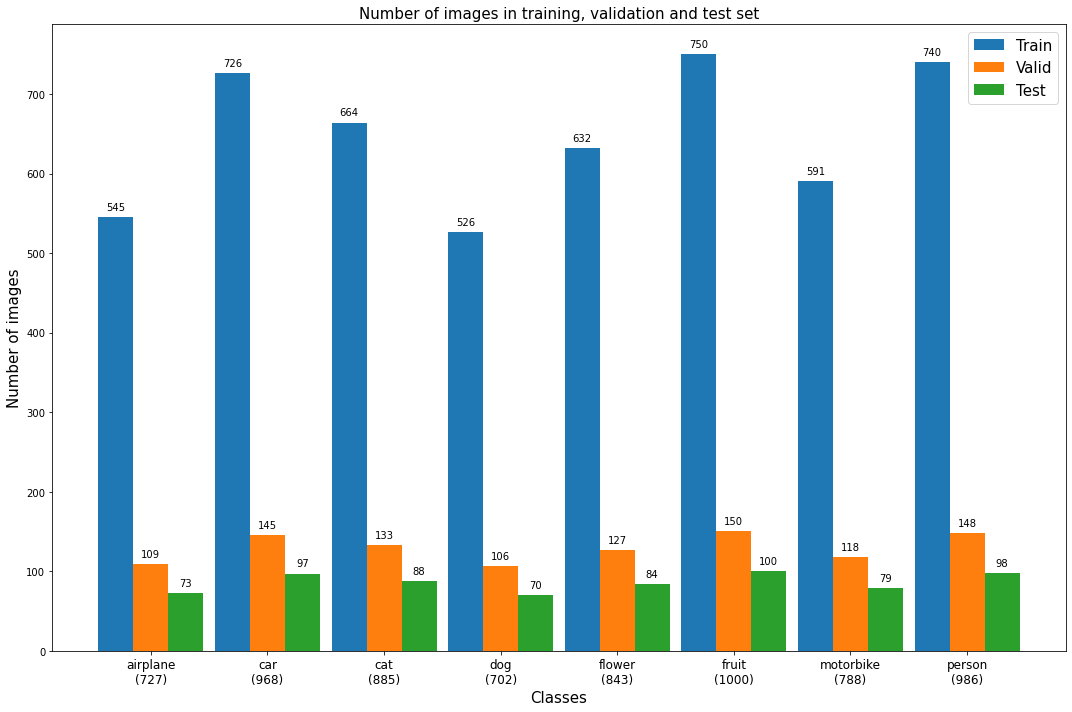

In [15]:
# Here I have made a grouped bar chart, with the code taken directly from matplotlib's website, with a few changes to suit for the purposes of this notebook

plt.rcParams["figure.figsize"] = [15,10] # size of the figure
width = 0.3  # the width of the bars
bar1 = np.arange(len(classes_natural_images)) # the label locations for train
bar2 = [i+width for i in bar1] # label locations for valid
bar3 = [i+width for i in bar2] # label locations for test
fig, ax = plt.subplots()
rects1 = ax.bar(bar1,train_qty,width,label="Train") # feeding in the data to the bar chart for train
rects2 = ax.bar(bar2,valid_qty,width,label="Valid") # for valid
rects3 = ax.bar(bar3,test_qty,width,label="Test") # for test
xlabels = [f"{x1}\n({x2})" for x1, x2, in zip(classes_natural_images,total_qty)] # printing the total image quantities of each class along with the name of the class
# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes',fontsize=15)
ax.set_ylabel('Number of images',fontsize=15)
ax.set_title('Number of images in training, validation and test set',fontsize=15)
ax.set_xticks(bar1+width)
ax.set_xticklabels(xlabels,fontsize=12)
ax.legend(fontsize=15)

# defining a function to annotate the values of each class per set
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,5),  
                    textcoords="offset points",
                    ha='center', va='bottom')


# calling the annotate function for each of the sets
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

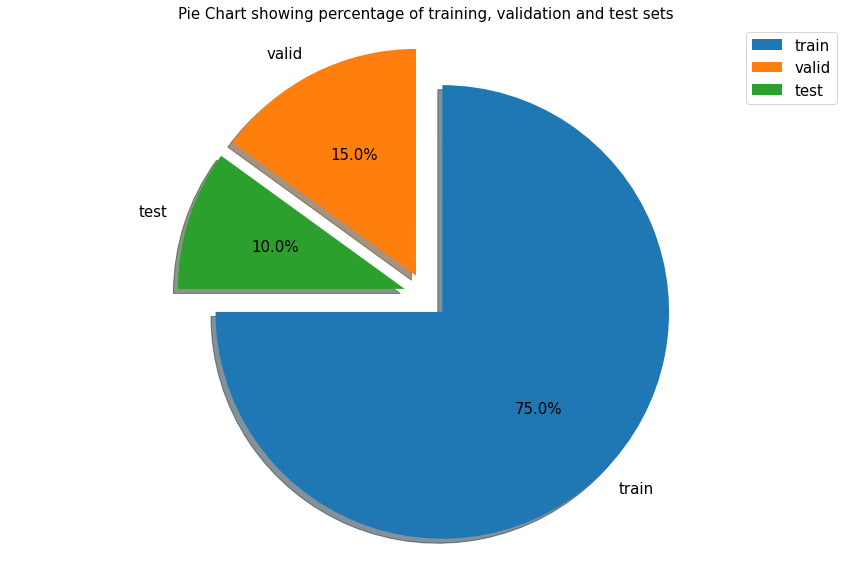

In [16]:
# Creating a pie-chart to see how the split was done
# This is also taken directly from matplotlib website with few modifications for this notebook

plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams['font.size'] = 15.0
explode_0 = (0.1, 0.1, 0.1)
fig0, ax0, = plt.subplots()
ax0.pie(total_of_sets, explode=explode_0, labels=['train','valid','test'], autopct='%1.1f%%',
      shadow=True, startangle=180, counterclock=True)
ax0.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax0.legend(fontsize=15)
ax0.set_title('Pie Chart showing percentage of training, validation and test sets',fontsize=15)

plt.show()

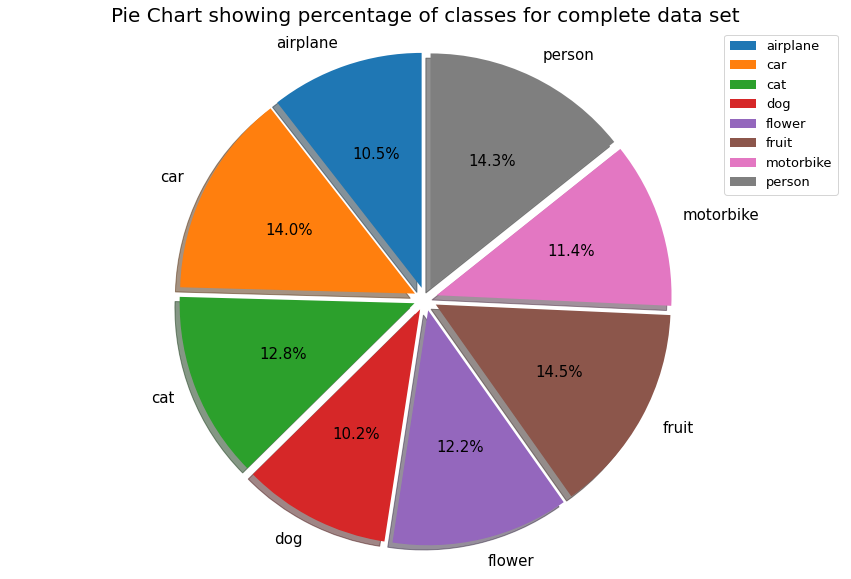

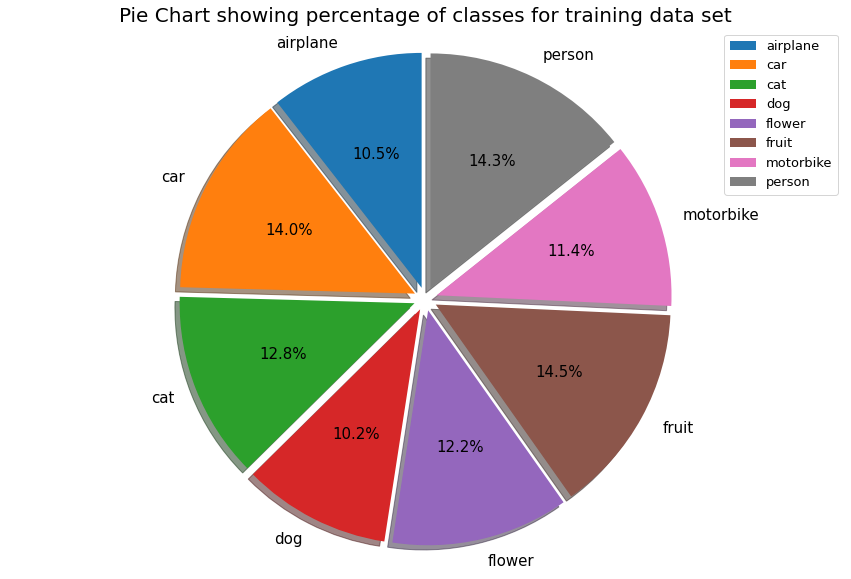

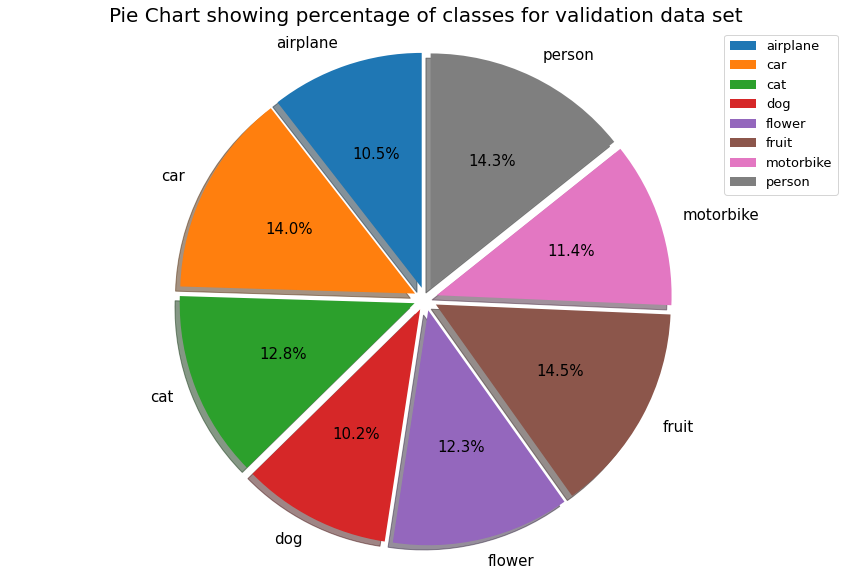

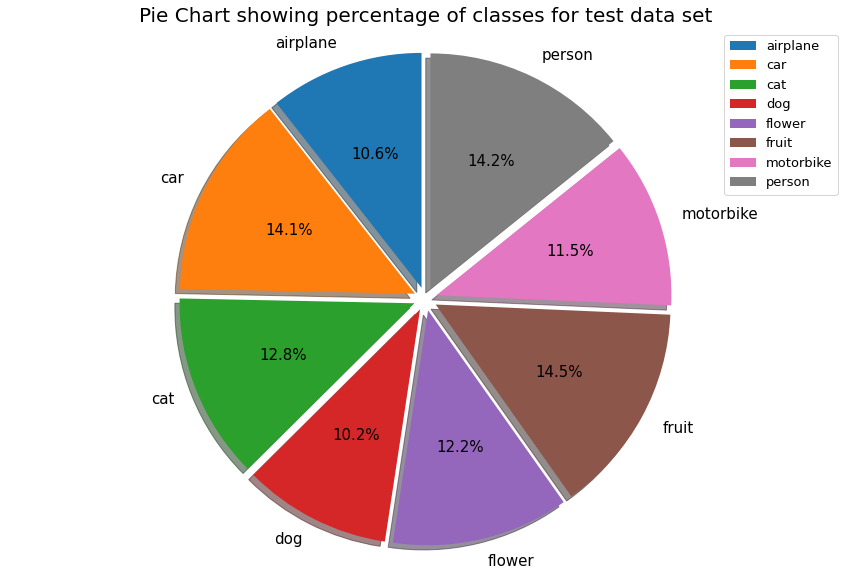

In [17]:
# Similarly, visualizing the split of each class, for the different sets

explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)


fig1, ax1, = plt.subplots()
fig2, ax2, = plt.subplots()
fig3, ax3, = plt.subplots()
fig4, ax4, = plt.subplots()
plt.rcParams['font.size'] = 15.0
plt.rcParams["figure.figsize"] = [15,10]
ax1.pie(total_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(fontsize=13)
ax1.set_title('Pie Chart showing percentage of classes for complete data set',fontsize=20)

ax2.pie(train_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.legend(fontsize=13)
ax2.set_title('Pie Chart showing percentage of classes for training data set',fontsize=20)

ax3.pie(valid_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.legend(fontsize=13)
ax3.set_title('Pie Chart showing percentage of classes for validation data set',fontsize=20)

ax4.pie(test_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.legend(fontsize=13)
ax4.set_title('Pie Chart showing percentage of classes for test data set',fontsize=20)

plt.show()

##### The classes are almost evenly distributed so that's good. I wil proceed with training the model with this split

In [18]:
class_labels = os.listdir('data/natural_images/train')
print(class_labels)

['cat', 'car', 'fruit', 'dog', 'person', 'flower', 'motorbike', 'airplane']


#### Making the training, validation and test directories and preprocessing using ImageGenerator.flor_from_directory()

In [19]:
# Now creating variables for paths to each of the train, valid, and test data directories

train_path = 'data/natural_images/train'
valid_path = 'data/natural_images/valid'
test_path = 'data/natural_images/test'

In [20]:
# Now I'll be using Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories.

# ImageDataGenerator.flow_from_directory() creates a DirectoryIterator, which helps in generating batches of normalized tensor image data 
# from the respective data directories.
# Specifying the path for the data to flow_from_directory() and target size. I have used 300x300. 
# This will resize all images to 300x300. This will be the input size for the neural network.

# classes takes a list with the class names
# batch_size of 5 is what I have selected. Although this dataset is not very large, but since it is a image classification problem, it will be slow to process

# I have set shuffle=False only for test set batches. It will be useful while evaluating the model. 
# we'll need to able to access the unshuffled labels for the test set. If shuffle is not specified, the dafult will be true, which means the sets will be shuffled.

# To ImageDataGenerator for each of the data set batch, I will be using the vgg16 preprocessor. What this does is that the mean of each channel of the image is taken,
# then the mean is subtracted from the actual pixel value. This makes the image color to be a little off, but vgg16 is known to do well for image classification.

train_set = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5)
valid_set = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5)
test_set = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5, shuffle=False)

Found 5174 images belonging to 8 classes.
Found 1036 images belonging to 8 classes.
Found 689 images belonging to 8 classes.


In [21]:
# Now preparing the train set for training with the next function. This generates a batch of the images and labels from the training set, with each batch size of 5 as defined above. 

imgs, labels = next(train_set)

In [22]:
# Plotting a function taken from TensorFlow's website to plot the processed images inside the notebook.

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


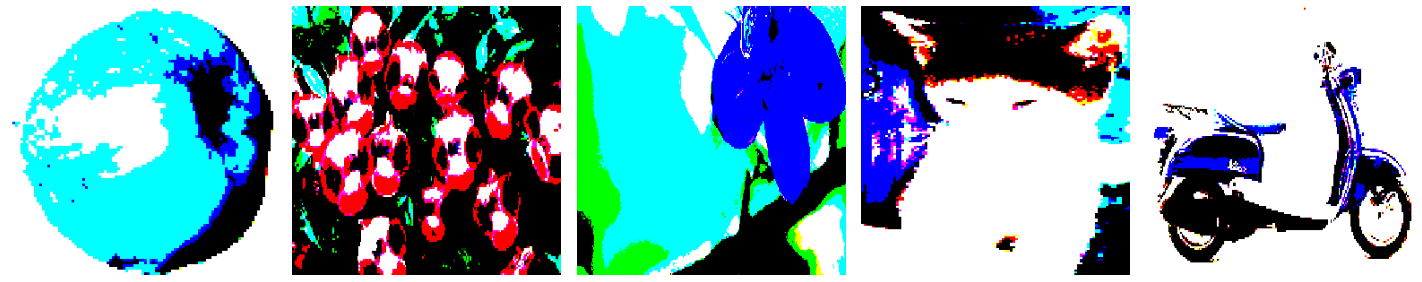

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [23]:
plotImages(imgs)
print(labels)

In [24]:
# This is a random batch from the training set. The array that is printed is a label for each class

In [25]:
# The classes have been one-hot encoded
# [1. 0. 0. 0. 0. 0. 0. 0.] is for airplane
# [0. 1. 0. 0. 0. 0. 0. 0.] is for car
# [0. 0. 1. 0. 0. 0. 0. 0.] is for cat
# [0. 0. 0. 1. 0. 0. 0. 0.] is for dog
# [0. 0. 0. 0. 1. 0. 0. 0.] is for flower
# [0. 0. 0. 0. 0. 1. 0. 0.] is for fruit
# [0. 0. 0. 0. 0. 0. 1. 0.] is for motorbike
# [0. 0. 0. 0. 0. 0. 0. 1.] is for person

## 3. First CNN Model

In [26]:
# Regarding parameters that are passed to the fit() function for the image data. 
# We have steps_per_epoch, which is generally kept same as the number of steps, of the sample batches
# It's taken from the training set before one epoch is finished and the next epoch is started.

# I've kept it as the number of samples in our training set divided by the batch size. 
# For every 100 training images, with batch size is 5, the steps_per_epoch is 20.

In [27]:
# For the model.fit(), we use validation_steps because we are also checking for validation set. 
# It does the same thing as steps_per_epoch, but for the validation set.

# Later, for predict(), we will set steps as the number of steps for test set

### Building the model

In [28]:
# For building the CNN, I will be using the Keras Sequential model

# First, a 2D convolutional layer is created, with 32 filters and kernel size of 3x3, and relu activation function.

# The choice of 32 filters looks random, but I have chosen it after multiple trial and error. I have also implemented hyperparameter tuning later in this notebook.
# And also created some ensembles. This model I have created is a typical 2 layer VGG16 model. With the first 2D layer with 32 filters and 2nd 2D layer with 64 filters
# Kernel size of 3x3 is very common size to use, so I have selected that
# I am using zero-padding with padding = 'same'.

# In the first layer only, I have defined the input_shape, which is the same shape as we did the preprocessing. 
# The images are 300 pixels high and 300 pixels wide and have 3 color channels: RGB. This gives the input_shape of (300,300,3).

# After the first 2D layer, a max pooling layer is used to pool and reduce the array size or dimensionality of the data, as in a standard VGG16 model. 
# The second 2D layer is followed by another similar MaxPool2D layer.

# The the output is flattened and then a Dense layer is created. 
# This Dense layer is the final, output layer of the neural network. It has 8 nodes, one for each class. 
# I'm using the softmax activation function on the output.

my_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(300,300,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=8, activation='softmax')
])

In [29]:
# Seeing a summary of the model by calling model.summary()

my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 360000)            0         
_________________________________________________________________
dense (Dense)                (None, 8)                 2880008   
Total params: 2,899,400
Trainable params: 2,899,400
Non-trainable params: 0
______________________________________________

In [30]:
# After the model is built, I will compile the model using the adam optimizer with a learning rate of 0.0001.
# This value is also selected after multiple trials and tuning, but using this value, the model generalizes best.
# loss is categorical_crossentropy, and  accuracy as the performance metric.

my_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [31]:
# Now training the model with 10 epochs.

In [32]:
model_full = my_model.fit(x=train_set,
                          steps_per_epoch=len(train_set),
                          validation_data=valid_set,
                          validation_steps=len(valid_set),
                          epochs=10,
                          verbose=2
                         )

Epoch 1/10
1035/1035 - 216s - loss: 8.5000 - accuracy: 0.8025 - val_loss: 0.5966 - val_accuracy: 0.8697
Epoch 2/10
1035/1035 - 211s - loss: 0.0990 - accuracy: 0.9720 - val_loss: 0.6864 - val_accuracy: 0.8832
Epoch 3/10
1035/1035 - 210s - loss: 0.0291 - accuracy: 0.9917 - val_loss: 0.8857 - val_accuracy: 0.8417
Epoch 4/10
1035/1035 - 210s - loss: 0.0761 - accuracy: 0.9861 - val_loss: 0.9148 - val_accuracy: 0.8707
Epoch 5/10
1035/1035 - 209s - loss: 0.0700 - accuracy: 0.9838 - val_loss: 1.3729 - val_accuracy: 0.8398
Epoch 6/10
1035/1035 - 209s - loss: 0.1021 - accuracy: 0.9768 - val_loss: 0.7074 - val_accuracy: 0.8678
Epoch 7/10
1035/1035 - 210s - loss: 0.0295 - accuracy: 0.9938 - val_loss: 0.7500 - val_accuracy: 0.8774
Epoch 8/10
1035/1035 - 209s - loss: 0.0329 - accuracy: 0.9934 - val_loss: 0.9509 - val_accuracy: 0.8745
Epoch 9/10
1035/1035 - 208s - loss: 0.0107 - accuracy: 0.9977 - val_loss: 1.2695 - val_accuracy: 0.8629
Epoch 10/10
1035/1035 - 209s - loss: 0.0402 - accuracy: 0.9936 -

In [33]:
# Performance of this simple model on training set is reaching 99% accuracy, but there is little bit of overfitting as validation accuracy is eaching only 87% 
# I will proceed with evaluation of this model and later attempt to reduce overfitting with hyperparameter tuning, creating ensembles and by using data augmentation

In [34]:
# For plotting the epoch vs train and validation set accuracy, I'm using the history from the neural net, 
# which retains the loss, accuracy of the training and validation
model_full.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

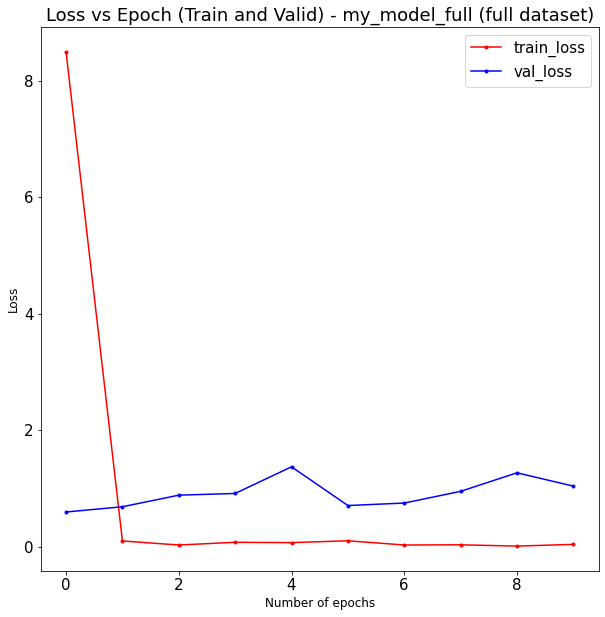

In [35]:
# plotting the epochs on the x axis and loss on y axis. Red is for training accuracy and blue for validation set
fig_full, ax_full = plt.subplots(figsize=(10,10))
ax_full.set_title('Loss vs Epoch (Train and Valid) - my_model_full (full dataset)')
ax_full.plot(model_full.history["loss"],'r', marker='.', label="train_loss")
ax_full.plot(model_full.history["val_loss"],'b', marker='.', label="val_loss")
ax_full.set_xlabel('Number of epochs',fontsize=12)
ax_full.set_ylabel('Loss',fontsize=12)
ax_full.legend()

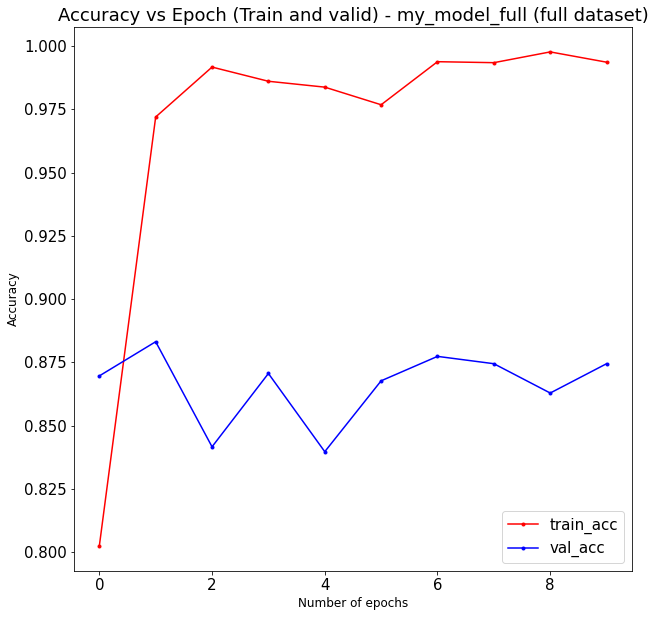

In [36]:
# plotting the epochs on the x axis and accuracy on y axis. Red is for training accuracy and blue for validation set
fig_full_2, ax_full_2 = plt.subplots(figsize=(10,10))
ax_full_2.set_title('Accuracy vs Epoch (Train and valid) - my_model_full (full dataset)')
ax_full_2.plot(model_full.history["accuracy"],'r', marker='.', label="train_acc")
ax_full_2.plot(model_full.history["val_accuracy"],'b', marker='.', label="val_acc")
ax_full_2.set_xlabel('Number of epochs',fontsize=12)
ax_full_2.set_ylabel('Accuracy',fontsize=12)
ax_full_2.legend()

### Testing the model on Test data

In [37]:
# Preparing The Test Data with the next function on test set

test_imgs, test_labels = next(test_set)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


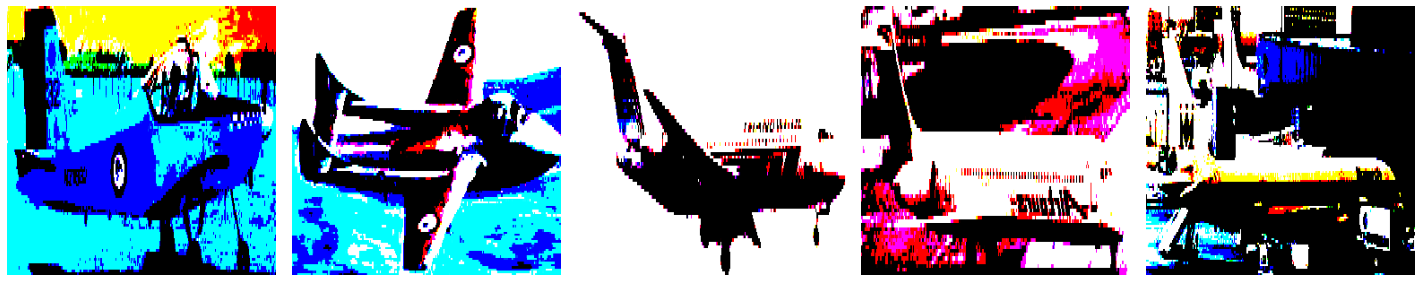

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [38]:
# test_set bathes were made using ImageDataGenerator.flow_from_directory() 
# Plotting it to see what it looks like

plotImages(test_imgs)
print(test_labels)

In [39]:
# Same like the training set, the test set is labeled with a one-hot encoding 
# [1. 0. 0. 0. 0. 0. 0. 0.] is for airplane
# [0. 1. 0. 0. 0. 0. 0. 0.] is for car
# [0. 0. 1. 0. 0. 0. 0. 0.] is for cat
# and so on

# And as I did not shuffle the test set, 
# the order of test data is like the one-hot encoding described above 
# And the color is off because of the VGG16 preprocessing while creating the data sets.

In [40]:
# Predicting On The Test Data with model.predict()

my_model_predictions = my_model.predict(x=test_set, steps=len(test_set), verbose=0)

In [41]:
# After running the predictions, let's see the rounded predictions and see what they look like.

np.round(my_model_predictions)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [42]:
# These are the labels that the model is predicting for the images. They are one hot-encoded
# Since the true labels are not shuffled, we can already see that there are some miss identified labels with some labels "3 ([0,0,1,0,0,0,0])" 
# appearing earlier than expected in the array.

In [43]:
# Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, I'll plot them using a confusion matrix.

# We create the confusion matrix using scikit-learn's confusion_matrix
# With the y_true set as the actual image labels and y_pred as the rounded values of the probabalistic predictions

cm = confusion_matrix(y_true=test_set.classes, y_pred=np.argmax(my_model_predictions, axis=-1))

In [44]:
# Let's see the unshuffled true labels for the test set with test_set.classes.

test_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [45]:
# Now defining the plot_confusion_matrix() function that I took directly from scikit-learn.

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [106]:
# Checking the class_indices for the labels so that we can pass it in the correct order to the confusion matrix.

test_set.class_indices

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [48]:
# Finally, plotting the confusion matrix.

Confusion matrix, without normalization
[[ 66   0   7   0   0   0   0   0]
 [  0  96   0   0   1   0   0   0]
 [  1   1  69  10   4   1   0   2]
 [  1   0  26  31  10   0   0   2]
 [  0   1   2   0  80   0   0   1]
 [  0   0   0   0   0 100   0   0]
 [  1   0   1   0   1   0  76   0]
 [  0   0   0   0   0   0   0  98]]


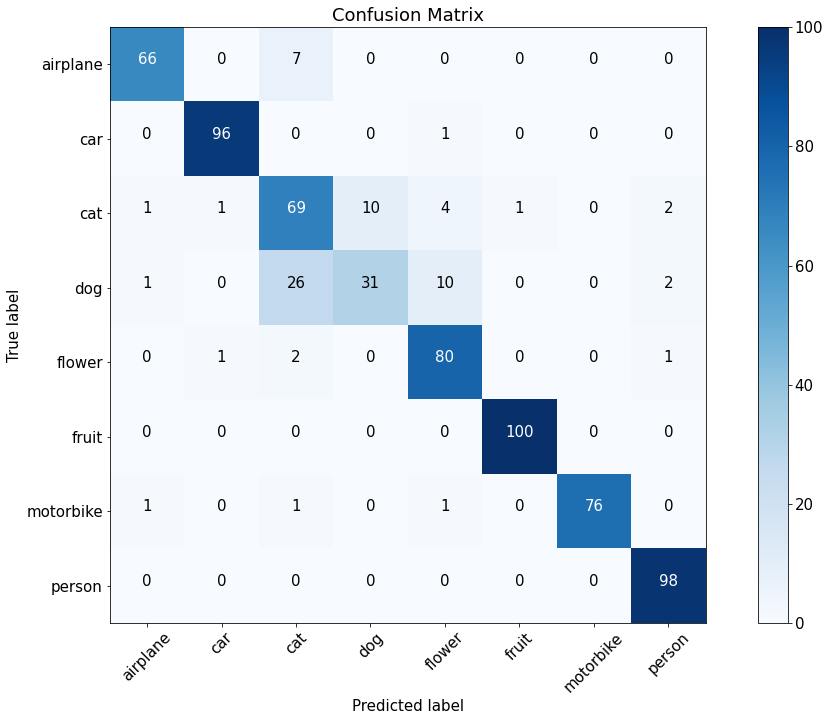

In [108]:
cm_plot_labels = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [50]:
# Evaluate the model
scores_cnn = my_model.evaluate(test_set)
print ("Accuracy: %.2f%%" %(scores_cnn[1]*100))

138/138 [==============================] - ETA: 0s - loss: 2.9082 - accuracy: 0.80 - ETA: 3s - loss: 2.4717 - accuracy: 0.86 - ETA: 4s - loss: 2.3019 - accuracy: 0.88 - ETA: 4s - loss: 1.6443 - accuracy: 0.91 - ETA: 4s - loss: 1.5876 - accuracy: 0.91 - ETA: 4s - loss: 1.3046 - accuracy: 0.92 - ETA: 4s - loss: 1.1187 - accuracy: 0.92 - ETA: 4s - loss: 1.1777 - accuracy: 0.90 - ETA: 4s - loss: 1.0392 - accuracy: 0.91 - ETA: 4s - loss: 0.9298 - accuracy: 0.92 - ETA: 4s - loss: 0.8414 - accuracy: 0.93 - ETA: 4s - loss: 0.8072 - accuracy: 0.93 - ETA: 4s - loss: 0.7426 - accuracy: 0.93 - ETA: 4s - loss: 0.6877 - accuracy: 0.94 - ETA: 4s - loss: 0.6416 - accuracy: 0.94 - ETA: 4s - loss: 0.6002 - accuracy: 0.94 - ETA: 3s - loss: 0.5638 - accuracy: 0.95 - ETA: 3s - loss: 0.5332 - accuracy: 0.95 - ETA: 3s - loss: 0.5598 - accuracy: 0.94 - ETA: 3s - loss: 0.5914 - accuracy: 0.93 - ETA: 3s - loss: 0.5899 - accuracy: 0.92 - ETA: 3s - loss: 0.5916 - accuracy: 0.91 - ETA: 3s - loss: 0.5659 - accuracy

##### This model is performing pretty well on the test set. The generalization is not the best, as there is definitely some overfitting. But the accuracy is not too bad
I will try to combat this issue with hyperparameter tuning, and then by creating ensembles and finally with data augmentation

#### Preparing the data for hyperparameter tuning

In [53]:
# I will do some hyperparameter tuning with a smaller dataset. 50% of images for training, 20% for validation and 10% for testing.
# For this, I hae created a new directory "data_2" with which I will do the same operations as above, only for a smaller number of images

In [54]:
!ls

INFO 6105 - Project List & Members.xlsx
Khajan_Joshi_Project.ipynb
Khajan_Joshi_Project_Natural_Images.pptx
Project_Basics.ipynb
Project_Basics_v2.ipynb
Project_Basics_v3.ipynb
Project_Basics_v4.ipynb
archive
data
data_2
my_dir
natural_images


In [55]:
os.chdir('data_2/natural_images')
print(len(glob.glob1('airplane','airplane*')))

727


In [56]:
os.chdir('../../')

In [57]:
!ls

INFO 6105 - Project List & Members.xlsx
Khajan_Joshi_Project.ipynb
Khajan_Joshi_Project_Natural_Images.pptx
Project_Basics.ipynb
Project_Basics_v2.ipynb
Project_Basics_v3.ipynb
Project_Basics_v4.ipynb
archive
data
data_2
my_dir
natural_images


In [58]:
classes_natural_images= ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit',  'motorbike', 'person']

In [59]:
# In the glob function for each class, we can see that I have selected a small number of images. Later I will plot with charts, how the split is done in percentages.
# Also, as all the operations are exactly the same as above, I will not repeat the comments.


os.chdir('data_2/natural_images')

if os.path.isdir('train') is False:
    airplane_dir = 'airplane'
    airplane_cnt = len(glob.glob1(airplane_dir,'airplane*'))
    print("Number of files in airplane directory before split: ",airplane_cnt)
    for c in classes_natural_images:
        os.makedirs(f'train/{c}')
        os.makedirs(f'valid/{c}')
        os.makedirs(f'test/{c}')
        os.chdir(f'{c}')
        for i in random.sample(glob.glob(f'{c}*'), round(len(glob.glob1(f'../{c}',f'{c}*'))*20/100)):
            shutil.move(i,f'../train/{c}')
        for i in random.sample(glob.glob(f'{c}*'), round(len(glob.glob1(f'../{c}',f'{c}*'))*5/100)):
            shutil.move(i,f'../valid/{c}')
        for i in random.sample(glob.glob(f'{c}*'), round(len(glob.glob1(f'../{c}',f'{c}*'))*2/100)):
            shutil.move(i,f'../test/{c}')
        os.chdir('../')
    airplane_cnt_new = len(glob.glob1(airplane_dir,'airplane*'))
    print("Number of files in airplane directory after split: ",airplane_cnt_new)
    
if os.path.isdir('train') is False:
    for r in classes_natural_images:
        shutil.rmtree(r)
print('Train-valid-test split complete. Please check the folders')
os.chdir('../../')

Number of files in airplane directory before split:  727
Number of files in airplane directory after split:  542
Train-valid-test split complete. Please check the folders


In [2]:
!ls

INFO 6105 - Project List & Members.xlsx
Khajan_Joshi_Project.ipynb
Khajan_Joshi_Project_Natural_Images.pptx
Khajan_Joshi_Project_trial.ipynb
Project_Basics.ipynb
Project_Basics_v2.ipynb
Project_Basics_v3.ipynb
Project_Basics_v4.ipynb
archive
data
data_2
my_dir
natural_images
output_tuner


In [61]:
for i in classes_natural_images:
    print(f'Number of {i} images in training set: ',len(glob.glob1(f'data_2/natural_images/train/{i}',f'{i}*')))
    print(f'Number of {i} images in validation set: ',len(glob.glob1(f'data_2/natural_images/valid/{i}',f'{i}*')))
    print(f'Number of {i} images in test set: ',len(glob.glob1(f'data_2/natural_images/test/{i}',f'{i}*')))
    print('\n')

Number of airplane images in training set:  145
Number of airplane images in validation set:  29
Number of airplane images in test set:  11


Number of car images in training set:  194
Number of car images in validation set:  39
Number of car images in test set:  15


Number of cat images in training set:  177
Number of cat images in validation set:  35
Number of cat images in test set:  13


Number of dog images in training set:  140
Number of dog images in validation set:  28
Number of dog images in test set:  11


Number of flower images in training set:  169
Number of flower images in validation set:  34
Number of flower images in test set:  13


Number of fruit images in training set:  200
Number of fruit images in validation set:  40
Number of fruit images in test set:  15


Number of motorbike images in training set:  158
Number of motorbike images in validation set:  32
Number of motorbike images in test set:  12


Number of person images in training set:  197
Number of person 

In [62]:
train_qty = list()
valid_qty = list()
test_qty = list()
for i in classes_natural_images:
    qty_train = len(glob.glob1(f'data_2/natural_images/train/{i}',f'{i}*'))
    train_qty.append(qty_train)  
    qty_valid = len(glob.glob1(f'data_2/natural_images/valid/{i}',f'{i}*'))
    valid_qty.append(qty_valid)  
    qty_test = len(glob.glob1(f'data_2/natural_images/test/{i}',f'{i}*'))
    test_qty.append(qty_test)
print('Classes: ',classes_natural_images)
print('train: ',train_qty)
print('valid: ',valid_qty)
print('test: ',test_qty)

Classes:  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
train:  [145, 194, 177, 140, 169, 200, 158, 197]
valid:  [29, 39, 35, 28, 34, 40, 32, 39]
test:  [11, 15, 13, 11, 13, 15, 12, 15]


In [63]:
total_qty=list(map(sum, zip(train_qty,valid_qty,test_qty)))
print(total_qty)

[185, 248, 225, 179, 216, 255, 202, 251]


In [64]:
train_qty_total=0
for i in train_qty:
    train_qty_total=train_qty_total+i
print('train total: ',train_qty_total)

valid_qty_total=0
for i in valid_qty:
    valid_qty_total=valid_qty_total+i
print('valid total: ',valid_qty_total)


test_qty_total=0
for i in test_qty:
    test_qty_total=test_qty_total+i
print('test total: ',test_qty_total)

total_of_sets = [train_qty_total,valid_qty_total,test_qty_total]
print(total_of_sets)

train total:  1380
valid total:  276
test total:  105
[1380, 276, 105]


#### Some data visualization

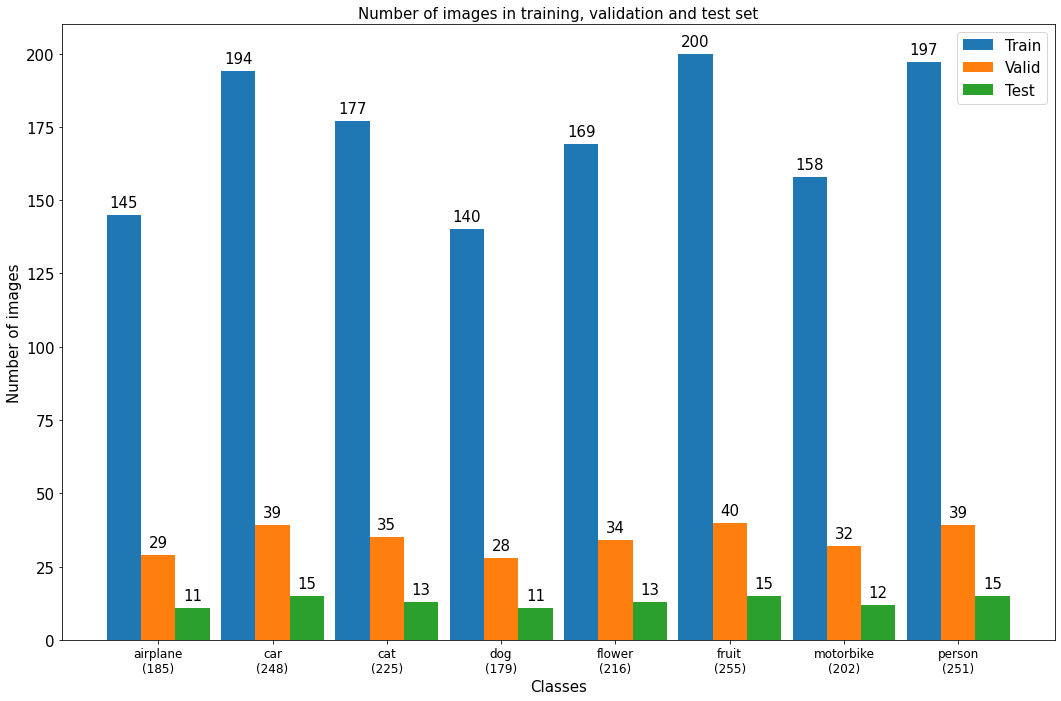

In [65]:
plt.rcParams["figure.figsize"] = [15,10]
bar1 = np.arange(len(classes_natural_images))
width = 0.3  
bar2 = [i+width for i in bar1]
bar3 = [i+width for i in bar2]
fig, ax = plt.subplots()
rects1 = ax.bar(bar1,train_qty,width,label="Train")
rects2 = ax.bar(bar2,valid_qty,width,label="Valid")
rects3 = ax.bar(bar3,test_qty,width,label="Test")
xlabels = [f"{x1}\n({x2})" for x1, x2, in zip(classes_natural_images,total_qty)]

ax.set_xlabel('Classes',fontsize=15)
ax.set_ylabel('Number of images',fontsize=15)
ax.set_title('Number of images in training, validation and test set',fontsize=15)
ax.set_xticks(bar1+width)
ax.set_xticklabels(xlabels,fontsize=12)
ax.legend(fontsize=15)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,5),  
                    textcoords="offset points",
                    ha='center', va='bottom')



autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

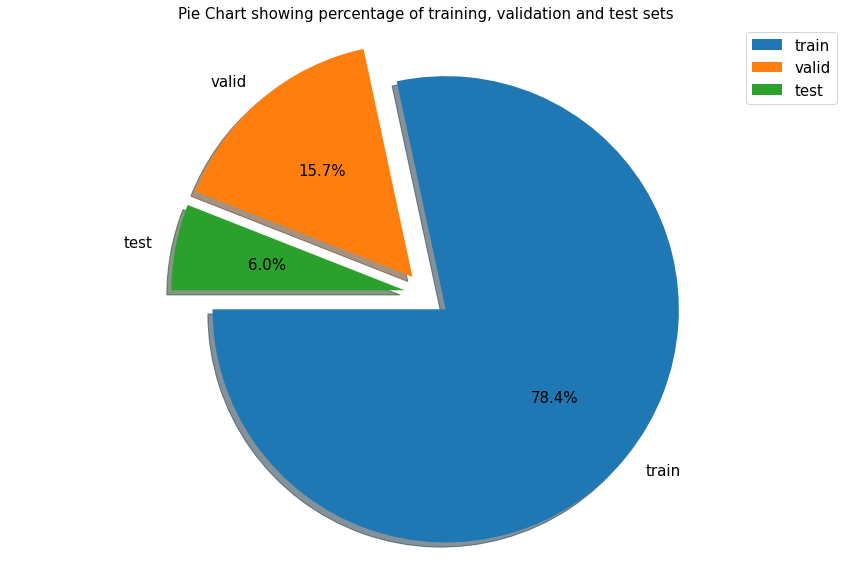

In [66]:
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams['font.size'] = 15.0
explode_0 = (0.1, 0.1, 0.1)
fig0, ax0, = plt.subplots()
ax0.pie(total_of_sets, explode=explode_0, labels=['train','valid','test'], autopct='%1.1f%%',
      shadow=True, startangle=180, counterclock=True)
ax0.axis('equal')  
ax0.legend(fontsize=15)
ax0.set_title('Pie Chart showing percentage of training, validation and test sets',fontsize=15)

plt.show()

##### We can see above that the split is almost like the previous, so I will proced with this

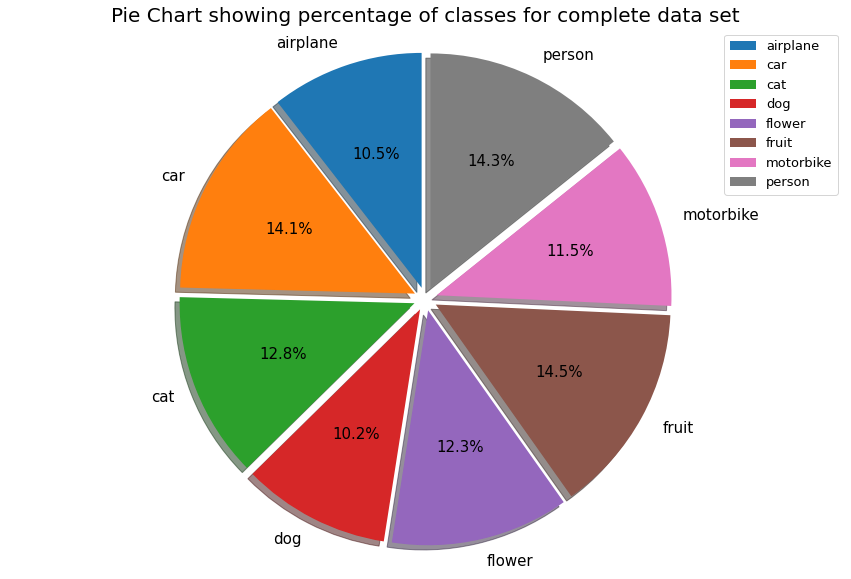

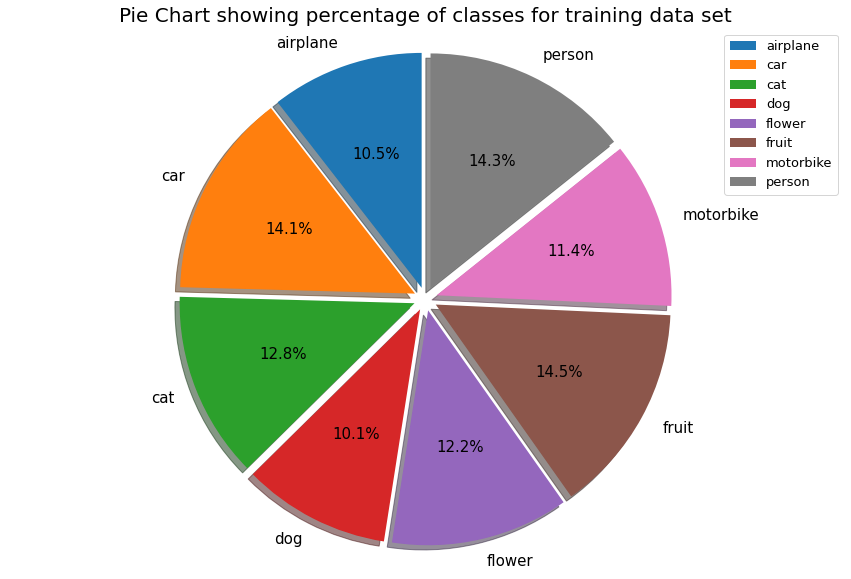

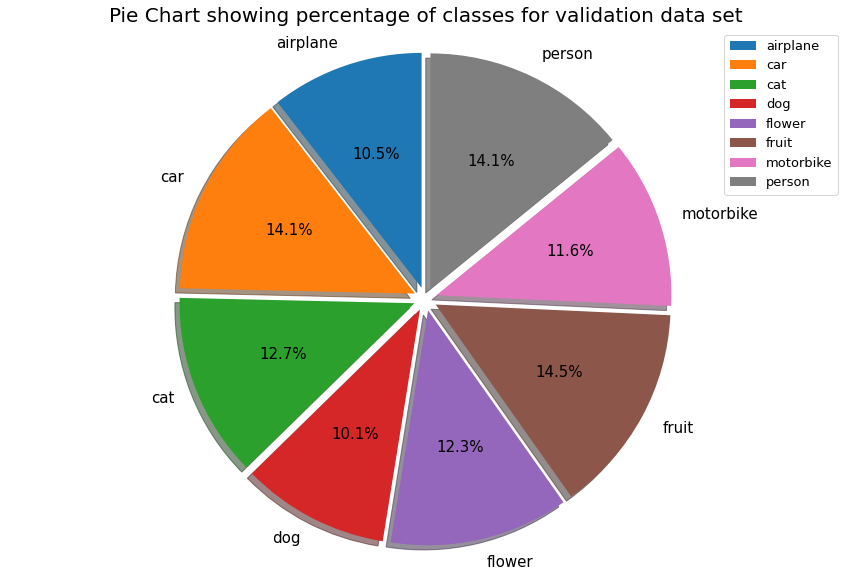

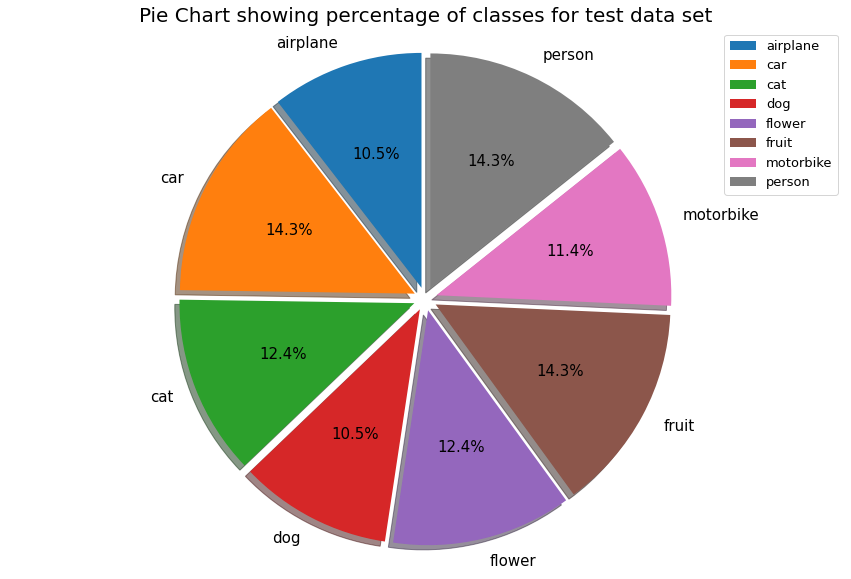

In [67]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)  


fig1, ax1, = plt.subplots()
fig2, ax2, = plt.subplots()
fig3, ax3, = plt.subplots()
fig4, ax4, = plt.subplots()
plt.rcParams['font.size'] = 15.0
plt.rcParams["figure.figsize"] = [15,10]
ax1.pie(total_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(fontsize=13)
ax1.set_title('Pie Chart showing percentage of classes for complete data set',fontsize=20)

ax2.pie(train_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.legend(fontsize=13)
ax2.set_title('Pie Chart showing percentage of classes for training data set',fontsize=20)

ax3.pie(valid_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.legend(fontsize=13)
ax3.set_title('Pie Chart showing percentage of classes for validation data set',fontsize=20)

ax4.pie(test_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.legend(fontsize=13)
ax4.set_title('Pie Chart showing percentage of classes for test data set',fontsize=20)

plt.show()

##### As expected, the classses are almot evenly distributed, so I will proced with training the model, before attempting hyperparameter tuning and comparing

In [68]:
class_labels = os.listdir('data_2/natural_images/train')
print(class_labels)

['cat', 'car', 'fruit', 'dog', 'person', 'flower', 'motorbike', 'airplane']


#### Making the training, validation and test directories and preprocessing using ImageGenerator.flor_from_directory()

In [110]:
# Same as before, setting the paths for the train, valid and test splits

train_path_tuned = 'data_2/natural_images/train'
valid_path_tuned = 'data_2/natural_images/valid'
test_path_tuned = 'data_2/natural_images/test'

In [111]:
# A similar model as above is used, to compare with the version with hyperparameter tuning

train_set_tuner = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path_tuned, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5)
valid_set_tuner = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path_tuned, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5)
test_set_tuner = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path_tuned, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5, shuffle=False)

Found 1380 images belonging to 8 classes.
Found 276 images belonging to 8 classes.
Found 105 images belonging to 8 classes.


In [112]:
# Same as before, preparing the training images for the fit

imgs_tuner, labels_tuner = next(train_set_tuner)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


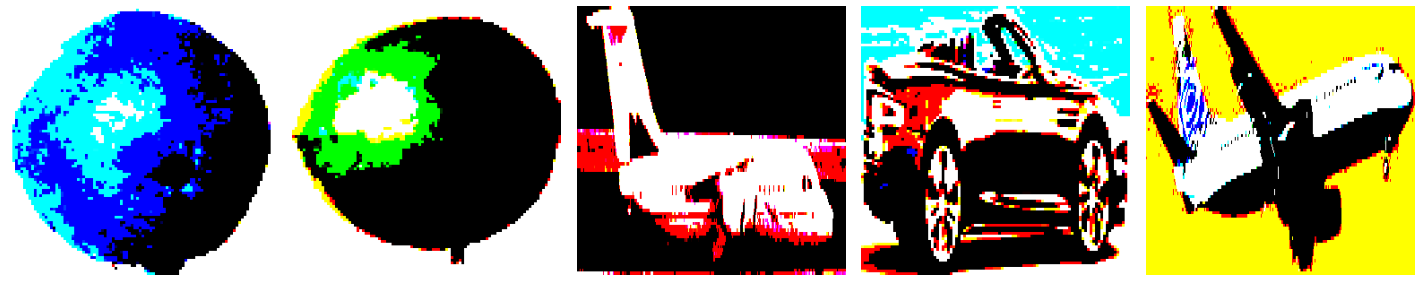

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [113]:
plotImages(imgs_tuner)
print(labels_tuner)

In [114]:
# This is how the first processed random batch from the training set looks. 

In [115]:
# Similarly the one-hot encoding is done
# [1. 0. 0. 0. 0. 0. 0. 0.] is for airplane
# [0. 1. 0. 0. 0. 0. 0. 0.] is for car
# [0. 0. 1. 0. 0. 0. 0. 0.] is for cat
# and so on

In [116]:
# Similarly like above, proceeding with the sequential model

In [117]:
# So let's build the model

### Building the model

In [118]:
# Same architecture as above 
# Then I will compare this model with the hyperparameter tuned model

model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(300,300,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=8, activation='softmax')
])

In [119]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 360000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2880008   
Total params: 2,899,400
Trainable params: 2,899,400
Non-trainable params: 0
____________________________________________

In [120]:
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [121]:
# Let's fit/train the model

In [122]:
model_2_fit = model_2.fit(x=train_set_tuner,
                          steps_per_epoch=len(train_set_tuner),
                          validation_data=valid_set_tuner,
                          validation_steps=len(valid_set_tuner),
                          epochs=10,
                          verbose=2
                         )

Epoch 1/10
276/276 - 61s - loss: 23.4691 - accuracy: 0.6913 - val_loss: 1.6428 - val_accuracy: 0.8333
Epoch 2/10
276/276 - 59s - loss: 0.3758 - accuracy: 0.9457 - val_loss: 1.7721 - val_accuracy: 0.8514
Epoch 3/10
276/276 - 59s - loss: 0.0888 - accuracy: 0.9804 - val_loss: 1.4862 - val_accuracy: 0.8587
Epoch 4/10
276/276 - 59s - loss: 0.1016 - accuracy: 0.9870 - val_loss: 2.4891 - val_accuracy: 0.8406
Epoch 5/10
276/276 - 61s - loss: 0.1511 - accuracy: 0.9855 - val_loss: 1.6609 - val_accuracy: 0.8587
Epoch 6/10
276/276 - 55s - loss: 0.0232 - accuracy: 0.9971 - val_loss: 3.5536 - val_accuracy: 0.7717
Epoch 7/10
276/276 - 55s - loss: 0.1364 - accuracy: 0.9790 - val_loss: 2.0322 - val_accuracy: 0.8551
Epoch 8/10
276/276 - 55s - loss: 0.1985 - accuracy: 0.9833 - val_loss: 1.8885 - val_accuracy: 0.8514
Epoch 9/10
276/276 - 55s - loss: 0.1060 - accuracy: 0.9833 - val_loss: 3.1521 - val_accuracy: 0.7862
Epoch 10/10
276/276 - 55s - loss: 0.1709 - accuracy: 0.9812 - val_loss: 1.4633 - val_accur

In [123]:
# Even with the small number of images, the CNN does pretty well on the training set, but with some overfitting as can see with the validation set accuracy

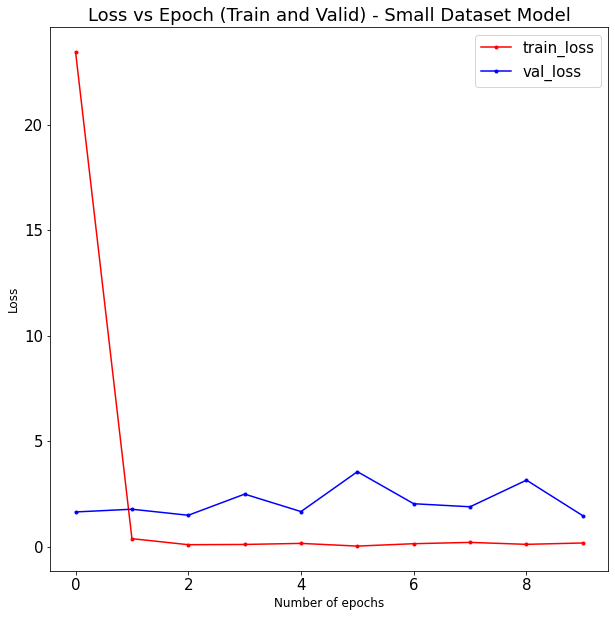

In [124]:
# plotting the epochs on the x axis and loss on y axis. Red is for training accuracy and blue for validation set
fig_pretuned, ax_pretuned = plt.subplots(figsize=(10,10))
ax_pretuned.set_title('Loss vs Epoch (Train and Valid) - Small Dataset Model')
ax_pretuned.plot(model_2_fit.history["loss"],'r', marker='.', label="train_loss")
ax_pretuned.plot(model_2_fit.history["val_loss"],'b', marker='.', label="val_loss")
ax_pretuned.set_xlabel('Number of epochs',fontsize=12)
ax_pretuned.set_ylabel('Loss',fontsize=12)
ax_pretuned.legend()

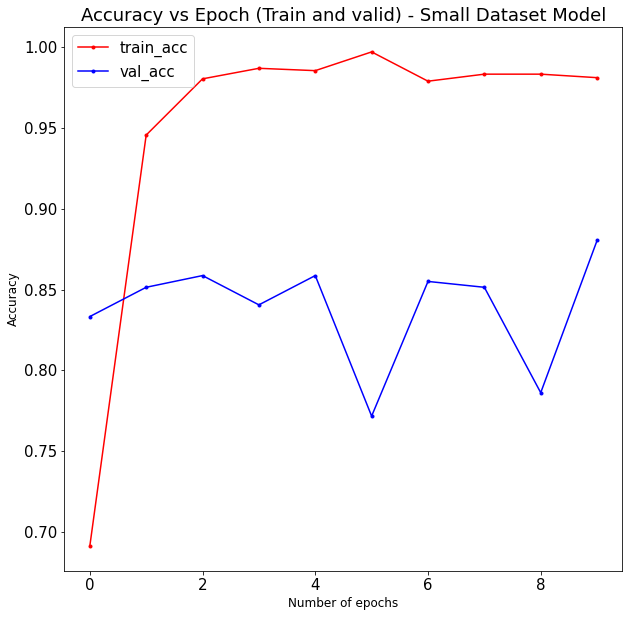

In [125]:
# plotting the epochs on the x axis and accuracy on y axis. Red is for training accuracy and blue for validation set
fig_pretuned_2, ax_pretuned_2 = plt.subplots(figsize=(10,10))
ax_pretuned_2.set_title('Accuracy vs Epoch (Train and valid) - Small Dataset Model')
ax_pretuned_2.plot(model_2_fit.history["accuracy"],'r', marker='.', label="train_acc")
ax_pretuned_2.plot(model_2_fit.history["val_accuracy"],'b', marker='.', label="val_acc")
ax_pretuned_2.set_xlabel('Number of epochs',fontsize=12)
ax_pretuned_2.set_ylabel('Accuracy',fontsize=12)
ax_pretuned_2.legend()

### Testing the model on Test data

In [126]:
test_imgs_tuner, test_labels_tuner = next(test_set_tuner)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


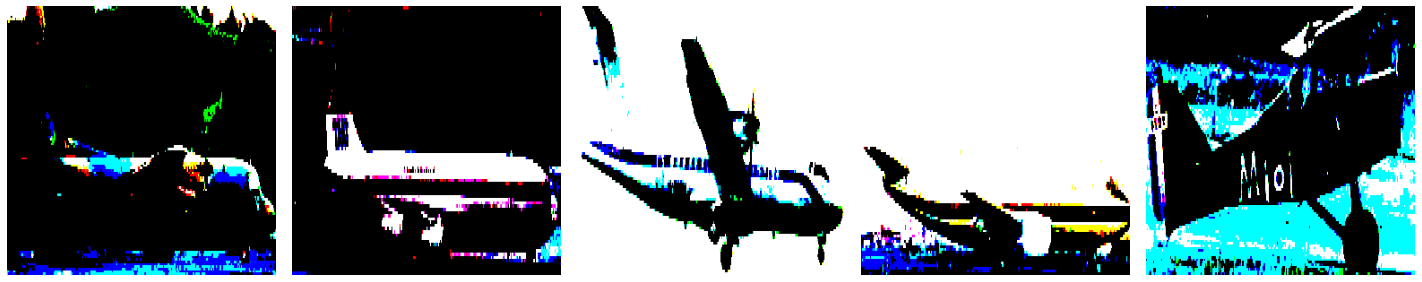

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [127]:
plotImages(test_imgs_tuner)
print(test_labels_tuner)

In [128]:
# Now predicting on the test set

In [129]:
predictions_2 = model_2.predict(x=test_set_tuner, steps=len(test_set_tuner), verbose=0)

In [130]:
np.round(predictions_2)

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 

In [131]:
# These are the labels that the model is predicting for our images. These are one-hot encoded as well.

In [132]:
# Creating the confusion matrix using scikit-learn

cm_2 = confusion_matrix(y_true=test_set_tuner.classes, y_pred=np.argmax(predictions_2, axis=-1))

In [133]:
# Actual labels

test_set_tuner.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)

In [134]:
# predicted labels

model_2.predict_classes(test_set_tuner)

array([2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 3, 2, 3, 2, 2, 2, 7, 0, 3, 3, 1, 7, 2, 3, 7, 6, 3,
       7, 2, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [135]:
test_set_tuner.class_indices

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [136]:
# Finally, we plot the confusion matrix.

Confusion matrix, without normalization
[[ 9  0  1  1  0  0  0  0]
 [ 0 15  0  0  0  0  0  0]
 [ 1  1  5  4  0  0  0  2]
 [ 0  0  2  6  0  0  1  2]
 [ 0  0  0  4  9  0  0  0]
 [ 0  0  0  0  0 15  0  0]
 [ 0  1  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0 15]]


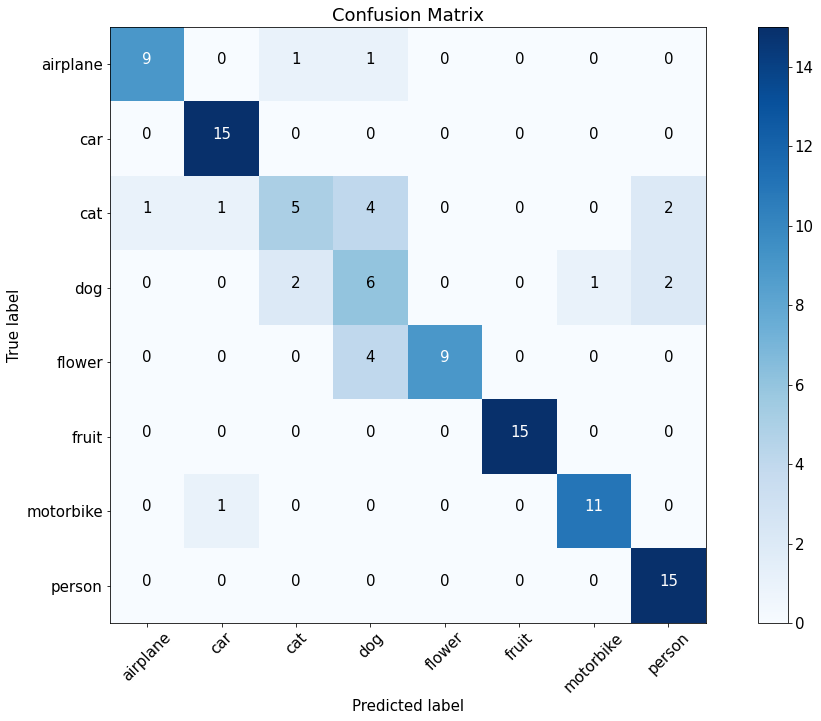

In [137]:
cm_plot_labels = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
plot_confusion_matrix(cm=cm_2, classes=cm_plot_labels, title='Confusion Matrix')

In [138]:
# Evaluate the model
scores_cnn_2 = model_2.evaluate(test_set_tuner)
print ("Accuracy: %.2f%%" %(scores_cnn_2[1]*100))

21/21 [==============================] - ETA: 0s - loss: 4.4322 - accuracy: 0.60 - ETA: 0s - loss: 1.4774 - accuracy: 0.86 - ETA: 0s - loss: 0.8864 - accuracy: 0.92 - ETA: 0s - loss: 0.8602 - accuracy: 0.86 - ETA: 0s - loss: 2.4693 - accuracy: 0.72 - ETA: 0s - loss: 3.0705 - accuracy: 0.70 - ETA: 0s - loss: 3.1820 - accuracy: 0.70 - ETA: 0s - loss: 3.3000 - accuracy: 0.70 - ETA: 0s - loss: 2.8600 - accuracy: 0.74 - ETA: 0s - loss: 2.5464 - accuracy: 0.76 - ETA: 0s - loss: 2.2785 - accuracy: 0.78 - ETA: 0s - loss: 2.0615 - accuracy: 0.80 - 1s 41ms/step - loss: 2.0615 - accuracy: 0.8095
Accuracy: 80.95%


### 4. Hyperprameter tuning

In [128]:
# For the tuning, I defined a function with a slightly deeper network. Let's see if that improves accuracy and generalization
# I have tuned few parameters such as number of filters with combinations of 16 and 32 for the first layer, 32 and 64 for the second.
# And a new third layer with trials for 64 and 128 filters
# In addition to that, I am also checking for different learning rate (0.001 and 0.0001)

def tuning_model(hp):
    model_tune = Sequential()
    model_tune.add(Conv2D(filters=hp.Int('1st Conv',min_value=16, max_value=32, step=16),
                            kernel_size=(3, 3),activation='relu',input_shape=(300,300,3), padding = 'same'))
    model_tune.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_tune.add(Conv2D(filters=hp.Int('2nd Conv',min_value=32, max_value=64, step=32),
                            kernel_size=(3, 3),activation='relu', padding = 'same'))
    model_tune.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_tune.add(Conv2D(filters=hp.Int('3rd Conv',min_value=64, max_value=128, step=64),
                            kernel_size=(3, 3),activation='relu', padding = 'same'))
    model_tune.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model_tune.add(Flatten())
    model_tune.add(Dense(8))
    model_tune.add(Activation("softmax"))
    model_tune.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model_tune

In [129]:
# Using scikit learn's RandomSearch to find the best model

search_tune=RandomSearch(tuning_model,
                       objective='val_accuracy',
                       max_trials=5,directory='output_tuner',project_name="natural_images_tune")

In [130]:
# Training the different combination with 5 epochs. This operation takes a long time to complete, which is why I have used a smaller dataset and lesser epochs
# Just to see the comparison

search_tune.search(train_set_tuner,epochs=5,validation_data=valid_set_tuner,verbose=1)

Epoch 1/5
276/276 [==============================] - ETA: 0s - loss: 17.3044 - accuracy: 0.0000e+0 - ETA: 21s - loss: 334.4273 - accuracy: 0.0000e+0 - ETA: 28s - loss: 533.1797 - accuracy: 0.0000e+0 - ETA: 31s - loss: 475.6687 - accuracy: 0.0000e+0 - ETA: 34s - loss: 428.5548 - accuracy: 0.0800    - ETA: 35s - loss: 408.2144 - accuracy: 0.100 - ETA: 36s - loss: 377.8343 - accuracy: 0.085 - ETA: 36s - loss: 340.6556 - accuracy: 0.100 - ETA: 37s - loss: 307.6899 - accuracy: 0.111 - ETA: 37s - loss: 282.6743 - accuracy: 0.120 - ETA: 37s - loss: 261.9898 - accuracy: 0.127 - ETA: 37s - loss: 242.5013 - accuracy: 0.116 - ETA: 37s - loss: 225.8749 - accuracy: 0.153 - ETA: 37s - loss: 211.2008 - accuracy: 0.142 - ETA: 37s - loss: 198.0014 - accuracy: 0.133 - ETA: 37s - loss: 186.6470 - accuracy: 0.137 - ETA: 38s - loss: 177.4477 - accuracy: 0.141 - ETA: 38s - loss: 167.8653 - accuracy: 0.144 - ETA: 38s - loss: 159.2701 - accuracy: 0.147 - ETA: 38s - loss: 151.4173 - accuracy: 0.160 - ETA: 38s 

Epoch 1/5
276/276 [==============================] - ETA: 0s - loss: 17.3638 - accuracy: 0.0000e+0 - ETA: 22s - loss: 267.4014 - accuracy: 0.1000  - ETA: 30s - loss: 290.2686 - accuracy: 0.200 - ETA: 34s - loss: 259.4131 - accuracy: 0.250 - ETA: 36s - loss: 213.2191 - accuracy: 0.200 - ETA: 37s - loss: 186.3301 - accuracy: 0.166 - ETA: 38s - loss: 161.5654 - accuracy: 0.142 - ETA: 38s - loss: 143.0943 - accuracy: 0.125 - ETA: 39s - loss: 127.8214 - accuracy: 0.111 - ETA: 39s - loss: 115.3177 - accuracy: 0.100 - ETA: 39s - loss: 104.9946 - accuracy: 0.127 - ETA: 39s - loss: 96.4929 - accuracy: 0.133 - ETA: 39s - loss: 89.2317 - accuracy: 0.13 - ETA: 39s - loss: 82.9732 - accuracy: 0.14 - ETA: 39s - loss: 77.6693 - accuracy: 0.14 - ETA: 40s - loss: 72.9397 - accuracy: 0.15 - ETA: 40s - loss: 68.7683 - accuracy: 0.15 - ETA: 39s - loss: 65.0636 - accuracy: 0.14 - ETA: 39s - loss: 61.7486 - accuracy: 0.13 - ETA: 39s - loss: 58.7642 - accuracy: 0.13 - ETA: 39s - loss: 56.0656 - accuracy: 0.1

Epoch 1/5
276/276 [==============================] - ETA: 0s - loss: 16.7820 - accuracy: 0.200 - ETA: 32s - loss: 266.4298 - accuracy: 0.200 - ETA: 41s - loss: 568.4323 - accuracy: 0.133 - ETA: 46s - loss: 599.4535 - accuracy: 0.150 - ETA: 48s - loss: 512.5018 - accuracy: 0.200 - ETA: 50s - loss: 448.5551 - accuracy: 0.200 - ETA: 51s - loss: 390.4272 - accuracy: 0.200 - ETA: 52s - loss: 347.4601 - accuracy: 0.175 - ETA: 53s - loss: 313.4013 - accuracy: 0.200 - ETA: 53s - loss: 284.1773 - accuracy: 0.200 - ETA: 54s - loss: 259.5111 - accuracy: 0.200 - ETA: 55s - loss: 239.0882 - accuracy: 0.183 - ETA: 55s - loss: 220.9169 - accuracy: 0.215 - ETA: 55s - loss: 205.5278 - accuracy: 0.200 - ETA: 55s - loss: 192.4513 - accuracy: 0.186 - ETA: 55s - loss: 181.4088 - accuracy: 0.200 - ETA: 55s - loss: 171.1972 - accuracy: 0.200 - ETA: 55s - loss: 161.9800 - accuracy: 0.200 - ETA: 55s - loss: 153.6053 - accuracy: 0.221 - ETA: 54s - loss: 146.3601 - accuracy: 0.230 - ETA: 54s - loss: 139.7129 - a

Epoch 1/5
276/276 [==============================] - ETA: 0s - loss: 8.4924 - accuracy: 0.40 - ETA: 23s - loss: 630.4432 - accuracy: 0.200 - ETA: 32s - loss: 850.8127 - accuracy: 0.133 - ETA: 36s - loss: 721.7439 - accuracy: 0.150 - ETA: 39s - loss: 602.3088 - accuracy: 0.120 - ETA: 41s - loss: 512.1776 - accuracy: 0.133 - ETA: 42s - loss: 442.6934 - accuracy: 0.142 - ETA: 43s - loss: 388.9710 - accuracy: 0.125 - ETA: 43s - loss: 346.0925 - accuracy: 0.133 - ETA: 43s - loss: 311.7003 - accuracy: 0.140 - ETA: 43s - loss: 283.5290 - accuracy: 0.145 - ETA: 43s - loss: 260.0887 - accuracy: 0.166 - ETA: 43s - loss: 240.3184 - accuracy: 0.169 - ETA: 43s - loss: 223.3242 - accuracy: 0.185 - ETA: 43s - loss: 208.5356 - accuracy: 0.200 - ETA: 43s - loss: 195.6258 - accuracy: 0.200 - ETA: 43s - loss: 184.2157 - accuracy: 0.211 - ETA: 43s - loss: 174.0594 - accuracy: 0.233 - ETA: 43s - loss: 165.0052 - accuracy: 0.231 - ETA: 43s - loss: 156.8161 - accuracy: 0.260 - ETA: 43s - loss: 149.4050 - acc

Epoch 1/5
276/276 [==============================] - ETA: 0s - loss: 20.4226 - accuracy: 0.0000e+0 - ETA: 16s - loss: 2103.1504 - accuracy: 0.100 - ETA: 22s - loss: 2251.6843 - accuracy: 0.13 - ETA: 25s - loss: 1748.3346 - accuracy: 0.15 - ETA: 27s - loss: 1417.4744 - accuracy: 0.16 - ETA: 28s - loss: 1189.5619 - accuracy: 0.13 - ETA: 29s - loss: 1020.6826 - accuracy: 0.11 - ETA: 29s - loss: 893.4575 - accuracy: 0.1000 - ETA: 29s - loss: 794.4268 - accuracy: 0.133 - ETA: 29s - loss: 715.2032 - accuracy: 0.140 - ETA: 29s - loss: 650.4479 - accuracy: 0.145 - ETA: 29s - loss: 596.5102 - accuracy: 0.150 - ETA: 30s - loss: 550.7546 - accuracy: 0.184 - ETA: 30s - loss: 511.5665 - accuracy: 0.185 - ETA: 29s - loss: 477.5964 - accuracy: 0.200 - ETA: 29s - loss: 447.8462 - accuracy: 0.225 - ETA: 29s - loss: 421.6149 - accuracy: 0.235 - ETA: 29s - loss: 398.2898 - accuracy: 0.233 - ETA: 29s - loss: 377.4356 - accuracy: 0.231 - ETA: 29s - loss: 358.6710 - accuracy: 0.220 - ETA: 29s - loss: 341.68

INFO:tensorflow:Oracle triggered exit


In [131]:
# With the get_best_models, and setting num_models as 1, I will fit on the training set and check generalization with the validation set
model_tuned=search_tune.get_best_models(num_models=1)[0]
model_tuned_fit = model_tuned.fit(train_set_tuner, epochs=5, validation_data=valid_set_tuner)

Epoch 1/5
276/276 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.00 - ETA: 19s - loss: 0.0258 - accuracy: 1.000 - ETA: 26s - loss: 0.0387 - accuracy: 1.000 - ETA: 29s - loss: 0.1223 - accuracy: 0.950 - ETA: 31s - loss: 0.1592 - accuracy: 0.920 - ETA: 32s - loss: 0.1334 - accuracy: 0.933 - ETA: 33s - loss: 0.1410 - accuracy: 0.942 - ETA: 33s - loss: 0.1328 - accuracy: 0.950 - ETA: 34s - loss: 0.1243 - accuracy: 0.955 - ETA: 34s - loss: 0.1312 - accuracy: 0.960 - ETA: 34s - loss: 0.1196 - accuracy: 0.963 - ETA: 34s - loss: 0.1285 - accuracy: 0.950 - ETA: 34s - loss: 0.1188 - accuracy: 0.953 - ETA: 34s - loss: 0.1116 - accuracy: 0.957 - ETA: 34s - loss: 0.1057 - accuracy: 0.960 - ETA: 35s - loss: 0.0993 - accuracy: 0.962 - ETA: 34s - loss: 0.1071 - accuracy: 0.952 - ETA: 35s - loss: 0.1485 - accuracy: 0.944 - ETA: 35s - loss: 0.1480 - accuracy: 0.947 - ETA: 35s - loss: 0.1527 - accuracy: 0.950 - ETA: 35s - loss: 0.1515 - accuracy: 0.952 - ETA: 35s - loss: 0.1449 -

In [132]:
# The below architecture performs best, let's see how it performs on the test set
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0

In [133]:
# Again, the same operations as above
model_tuned_fit.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

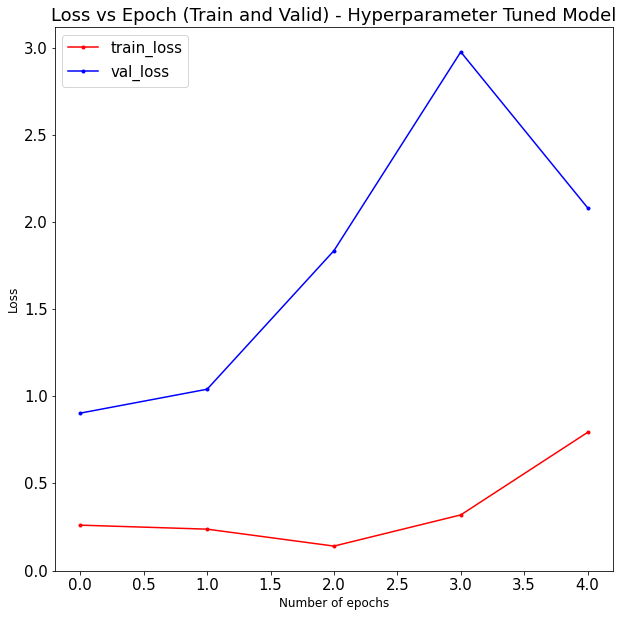

In [134]:
# plotting the epochs on the x axis and loss on y axis. Red is for training accuracy and blue for validation set
fig_tuned, ax_tuned = plt.subplots(figsize=(10,10))
ax_tuned.set_title('Loss vs Epoch (Train and Valid) - Hyperparameter Tuned Model')
ax_tuned.plot(model_tuned_fit.history["loss"],'r', marker='.', label="train_loss")
ax_tuned.plot(model_tuned_fit.history["val_loss"],'b', marker='.', label="val_loss")
ax_tuned.set_xlabel('Number of epochs',fontsize=12)
ax_tuned.set_ylabel('Loss',fontsize=12)
ax_tuned.legend()

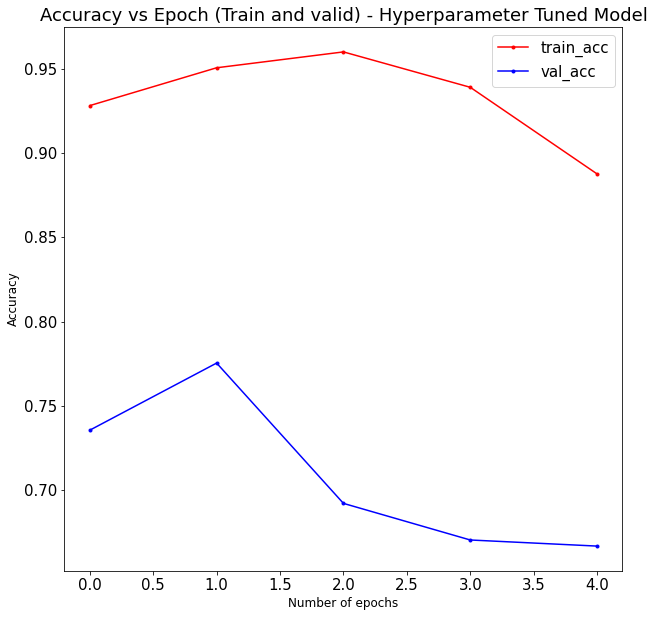

In [135]:
# plotting the epochs on the x axis and accuracy on y axis. Red is for training accuracy and blue for validation set
fig_tuned_2, ax_tuned_2 = plt.subplots(figsize=(10,10))
ax_tuned_2.set_title('Accuracy vs Epoch (Train and valid) - Hyperparameter Tuned Model')
ax_tuned_2.plot(model_tuned_fit.history["accuracy"],'r', marker='.', label="train_acc")
ax_tuned_2.plot(model_tuned_fit.history["val_accuracy"],'b', marker='.', label="val_acc")
ax_tuned_2.set_xlabel('Number of epochs',fontsize=12)
ax_tuned_2.set_ylabel('Accuracy',fontsize=12)
ax_tuned_2.legend()

##### We can see that there is still overfitting with a more complex model, with losses higher than before

### Testing the model on Test data

In [136]:
# Preparing The Test Data
test_imgs_tuned, test_labels_tuned = next(test_set_tuner)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


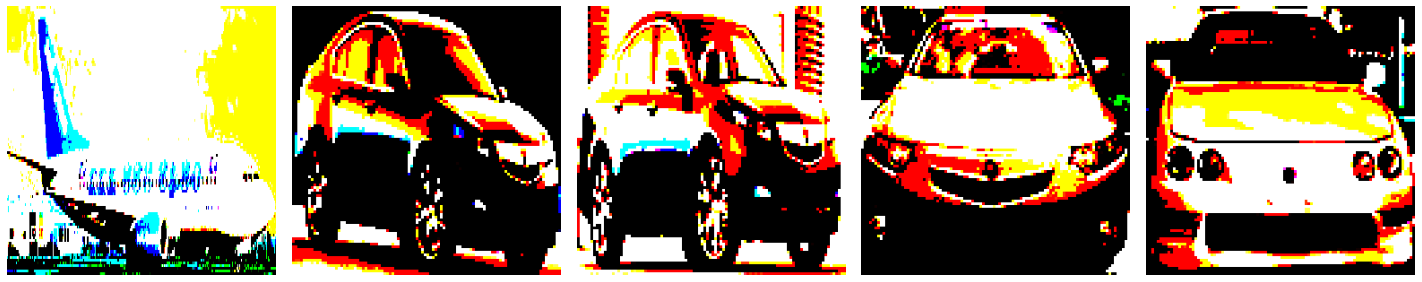

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


In [137]:
plotImages(test_imgs_tuned)
print(test_labels_tuned)

In [138]:
# Just as before, the test set is labeled with a one-hot encoding 
# [1. 0. 0. 0. 0. 0. 0. 0.] is for airplane
# [0. 1. 0. 0. 0. 0. 0. 0.] is for car
# [0. 0. 1. 0. 0. 0. 0. 0.] is for cat
# and so on

In [139]:
# Predicting on The test set

hypertuned_predictions = model_tuned.predict(x=test_set_tuner, steps=len(test_set_tuner), verbose=0)

In [140]:
np.round(hypertuned_predictions)

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 

In [141]:
# These are the labels that the model is predicting for the images.

In [142]:
# Creating the confusion matrix using scikit-learn

hypertuned_cm = confusion_matrix(y_true=test_set_tuner.classes, y_pred=np.argmax(hypertuned_predictions, axis=-1))

In [143]:
# Checking the unshuffled true labels for the test set by calling test_batches.classes.

test_set_tuner.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)

In [144]:
model_tuned.predict_classes(test_set_tuner)

array([2, 0, 4, 1, 6, 0, 0, 0, 3, 0, 0, 4, 1, 1, 1, 0, 1, 0, 1, 1, 4, 5,
       1, 3, 1, 1, 1, 1, 4, 3, 4, 4, 2, 4, 4, 4, 2, 3, 7, 4, 2, 2, 4, 1,
       4, 3, 2, 5, 0, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 7, 5, 5, 5,
       5, 6, 5, 5, 5, 5, 5, 1, 5, 1, 5, 5, 1, 6, 2, 1, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 0, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7])

In [145]:
# We can get insights on the accuracy by just comparing the arrays of the true and predicted labels. But we will visualize with a confusion matrix

In [146]:
test_set_tuner.class_indices

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [147]:
# Finally, plotting the confusion matrix.

Confusion matrix, without normalization
[[ 6  1  1  1  1  0  1  0]
 [ 2  9  0  1  2  1  0  0]
 [ 0  2  2  2  6  0  0  1]
 [ 1  1  3  1  4  1  0  0]
 [ 0  0  0  1 11  0  0  1]
 [ 0  2  0  0  0 12  1  0]
 [ 0  2  1  0  0  0  9  0]
 [ 1  0  0  0  1  0  0 13]]


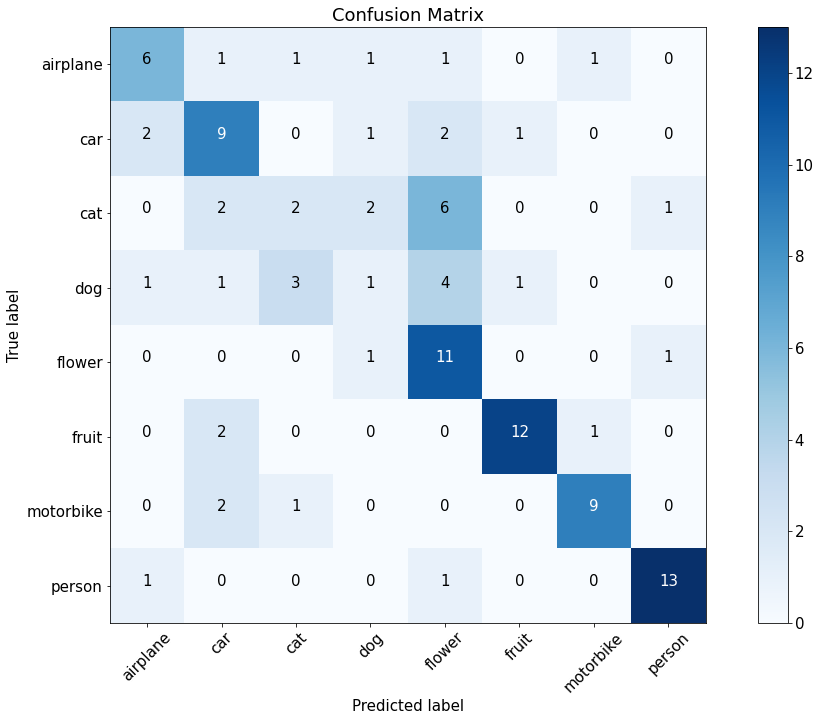

In [148]:
cm_plot_labels = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
plot_confusion_matrix(cm=hypertuned_cm, classes=cm_plot_labels, title='Confusion Matrix')

In [149]:
# Evaluate the model
scores_cnn_tuned = model_tuned.evaluate(test_set_tuner)
print ("Accuracy: %.2f%%" %(scores_cnn_tuned[1]*100))

21/21 [==============================] - ETA: 0s - loss: 4.1990 - accuracy: 0.20 - ETA: 0s - loss: 1.6198 - accuracy: 0.60 - ETA: 0s - loss: 2.7647 - accuracy: 0.56 - ETA: 0s - loss: 3.2147 - accuracy: 0.45 - ETA: 0s - loss: 3.5474 - accuracy: 0.37 - ETA: 0s - loss: 3.2138 - accuracy: 0.41 - ETA: 0s - loss: 2.8290 - accuracy: 0.47 - ETA: 0s - loss: 2.5038 - accuracy: 0.52 - ETA: 0s - loss: 2.6511 - accuracy: 0.52 - ETA: 0s - loss: 2.4046 - accuracy: 0.56 - ETA: 0s - loss: 2.2157 - accuracy: 0.60 - 1s 29ms/step - loss: 2.2157 - accuracy: 0.6000
Accuracy: 60.00%


##### It seems that a complex model is not generalizing very well. Let's try ensembling different models

### 5. Creating Ensembles

In [42]:
# In the ensembles, I will again make deeper neural networks. I will create an ensemble of 4 neural nets. 
# I will be using batchnormalization in these models. This may help in accelerating the training process
# I am also using a dropout of 0.4. Usually dropout of 0.5 is used for intermediate layers in deeper networks
# And 0.2 or lower is used for the input layer. I am using an aribitrary value of 0.4

nets = 4
model = [0] *nets

for j in range(nets):
    model[j] = Sequential()
    #First Layer
    model[j].add(Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = (300,300,3)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = (3,3), activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = (3,3), strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Second Layer
    model[j].add(Conv2D(64, kernel_size = (3,3), activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = (3,3), activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = (3,3), strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Third layer
    model[j].add(Conv2D(128, kernel_size = (3,3), activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))

    #Output layer
    model[j].add(Dense(8, activation='softmax'))

    # Compile each model
    model[j].compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

    
print('Ensembles created')

Ensembles created


In [43]:
#LR Reduction from scikit learn's Callback dynamically reduces the learning rate if there is no improvement in the model. 
# Patience of 3 signifies that after 3 epochs, the LR will be reduced.

learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)

In [44]:
# To access the model accuracies, I will iterate using the history from the learning and store for each model iteratively
# The dataset for training the models will be the complete set which I initially created and not the small set used for tuning hyperparameters

history = [0] * nets
epochs = 5

for i in range(nets):
    print(f'CNN : {i+1}')
    history[i] = model[i].fit((train_set), 
                              epochs = epochs, steps_per_epoch = len(train_set),
                              validation_data = valid_set,
                              callbacks=[learning_rate_reduction], verbose=0)

    print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(i+1,epochs,max(history[i].history['accuracy']),
                                                                                                         max(history[i].history['val_accuracy']) ))

CNN : 1
CNN Model 1: Epochs=5, Training accuracy=0.94956, Validation accuracy=0.85328
CNN : 2
CNN Model 2: Epochs=5, Training accuracy=0.94356, Validation accuracy=0.84363
CNN : 3
CNN Model 3: Epochs=5, Training accuracy=0.92907, Validation accuracy=0.83108
CNN : 4
CNN Model 4: Epochs=5, Training accuracy=0.94240, Validation accuracy=0.84170


In [45]:
# Combining the results for checking how well the ensembled models generalize on the test set
results = np.zeros((test_imgs.shape[0],8)) 
for j in range(nets):
    results = results + model[j].predict(test_imgs)

results = np.argmax(results,axis = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


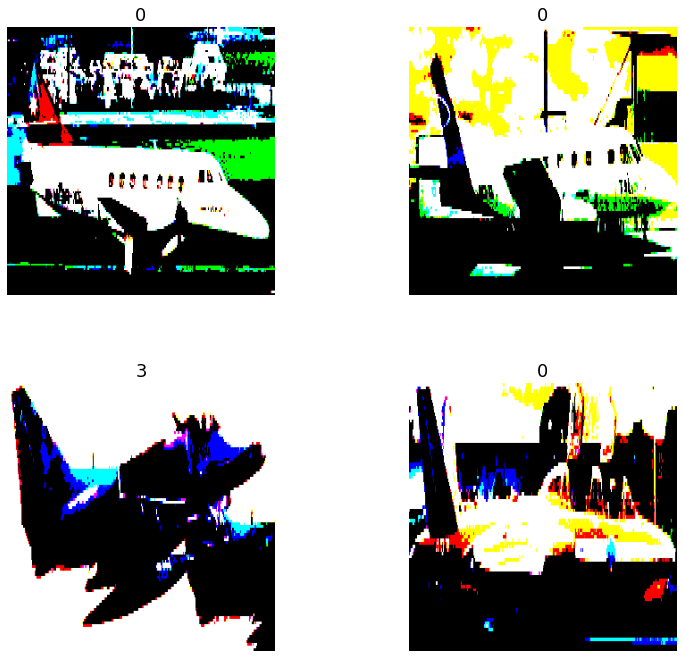

In [46]:
# I will plot some of the results to see if the labels are predicted well.
# The output label will be the class indices, which is as follows:
#  'airplane': 0,
#  'car': 1,
#  'cat': 2,
#  'dog': 3,
#  'flower': 4,
#  'fruit': 5,
#  'motorbike': 6,
#  'person': 7

L = 2
W = 2
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    if i<5:
        
        axes[i].imshow(test_imgs[i])
        axes[i].set_title(results[i])
        axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

We can see from the above 4 preditions, 3 of them are right. It seems the ensemble doesn't generalize very well.<br>
Let's see how it does on the test set

In [47]:
# I will take the predictions of the individual models and evaluate the model
# For the first individual net:
ens_arr0 = model[0].predict_classes(test_set)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [48]:
# For the second individual net:
ens_arr1 = model[1].predict_classes(test_set)

In [49]:
# For the third individual net:
ens_arr2 = model[2].predict_classes(test_set)

In [50]:
# For the last individual net:
ens_arr3 = model[3].predict_classes(test_set)

In [51]:
# Here I am simply adding all the model predictions and taking a simple average to make an ensemble

ens_sum_1 = np.add(ens_arr0, ens_arr1)
ens_sum_2 = np.add(ens_sum_1, ens_arr2)
ens_sum_final = np.add(ens_sum_2, ens_arr3)    
ens_avg = np.round(ens_sum_final/4)
ens_avg

array([1., 1., 4., 0., 1., 0., 1., 2., 0., 0., 2., 0., 0., 2., 0., 0., 0.,
       0., 0., 2., 0., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1.,
       2., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 3., 2., 1., 1., 1., 1.,
       2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.,
       4., 3., 2., 2., 3., 2., 2., 2., 3., 3., 2., 1., 3., 2., 3., 2., 3.,
       2., 2., 2., 2., 2., 3., 2., 2., 4., 2., 3., 4., 2., 2., 2., 2., 3.,
       2., 2., 3., 4., 5.

In [52]:
# Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, we’ll plot them in a confusion matrix.

# We create the confusion matrix using scikit-learn

ens_cm = confusion_matrix(y_true=test_set.classes, y_pred=ens_avg)

Confusion matrix, without normalization
[[54 10  8  0  1  0  0  0]
 [ 0 83 12  2  0  0  0  0]
 [ 0  1 57 22  7  1  0  0]
 [ 0  0 33 23 13  1  0  0]
 [ 0  0  2 14 68  0  0  0]
 [ 0  0  0  2  7 91  0  0]
 [ 0  0  1  0  3  3 72  0]
 [ 0  0  0  1  0  1  3 93]]


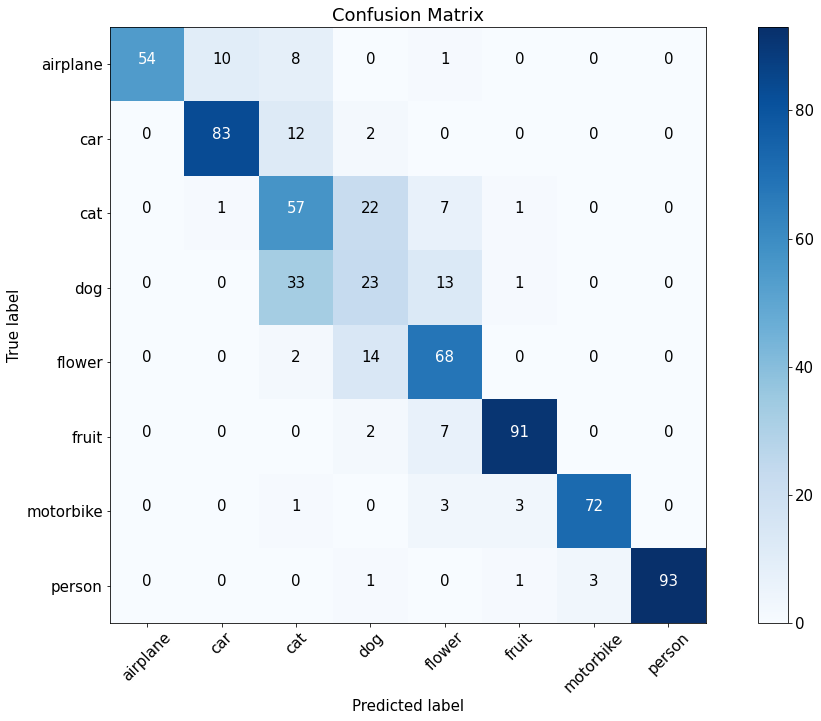

In [53]:
cm_plot_labels = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
plot_confusion_matrix(cm=ens_cm, classes=cm_plot_labels, title='Confusion Matrix')

In [54]:
# Evaluating the ensembled models on the test set
# For getting the percentage of correct predictions, I will do some manual mathematical calculations as the above operations have converted the predictions to a numpy array

In [55]:
# Evaluate the model

# As we know from the ful dataset split, there are 689 images in the test set. Let's compare between the predicted and true arrays to get number of correct predictions
# Using simple subtraction of each value in the area
difference_arr = np.subtract(ens_avg,test_set.classes)
#np.count_nonzero(difference_arr)
num_zeros = (difference_arr == 0).sum()
print("Number of correct predictions: ",num_zeros)


Number of correct predictions:  541


In [56]:
print("Ensemble Accuracy for test set: %.2f%%" %(100-((689-num_zeros)/689)*100))

Ensemble Accuracy for test set: 78.52%


The ensemble does not generalize very well.
Let me try data augmentation on the complete dataset to see if overfitting can be reduced

### 6. Data Augmentation

In [51]:
# Here I am creating the ImageDataGnerator for augmenting images
# By doing simple operations on the images, like rotation, zoom, flip, etc. we can create copies of images which can help in increasing the dataset size
# which in turn can help reduce overfitting and make the model generalize better

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [52]:
# defining a function which returns a random image from each class's directory which I will then use for generating augmented images

def img_class(classes__nat_img):
    chosen_image = random.choice(os.listdir(f'data/natural_images/train/{classes__nat_img}'))
    image_path = f'data/natural_images/train/{classes__nat_img}/' + chosen_image
    image = np.expand_dims(plt.imread(image_path),0)
    plt.imshow(image[0])
    return image

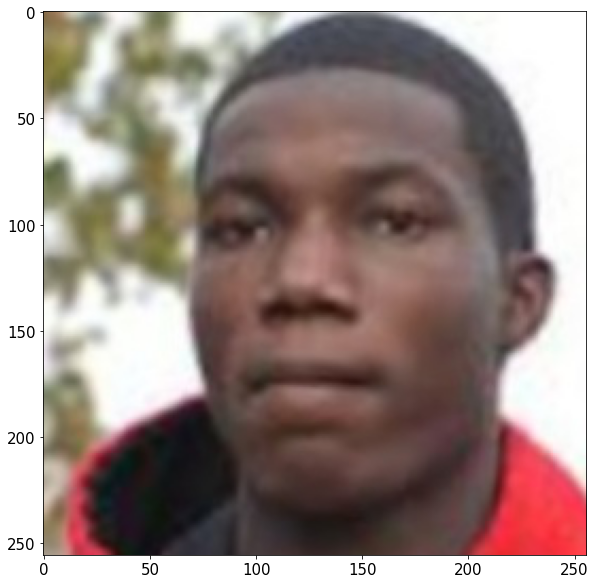

In [53]:
# Now creating a loop in which around 150 images will be generated using 10 different images
# In train directory's sub-directory for each class, there will be augmented images. 
# For example in fruit sub-directory augmented images will be named like "fruit_aug_0_xxxx"

for m in range(10):
    for j in classes_natural_images:   
        i=0
        if not j == '.DS_Store':
            for batch in gen.flow(img_class(j), save_to_dir=f'data/natural_images/train/{j}', save_prefix=f'{j}_aug', save_format='jpeg'):
                i+=1
                if i>15:
                    break

In [54]:
# The above is a sample image that was used for data augmentation. This can be verified in the "person" sub-directory in "train" directory inside "data"

In [55]:
# Again doing the same operations as before for preparing some charts
for i in classes_natural_images:
    print(f'Number of {i} images in training set: ',len(glob.glob1(f'data/natural_images/train/{i}',f'{i}*')))
    print(f'Number of {i} images in validation set: ',len(glob.glob1(f'data/natural_images/valid/{i}',f'{i}*')))
    print(f'Number of {i} images in test set: ',len(glob.glob1(f'data/natural_images/test/{i}',f'{i}*')))
    print('\n')

Number of airplane images in training set:  703
Number of airplane images in validation set:  109
Number of airplane images in test set:  73


Number of car images in training set:  884
Number of car images in validation set:  145
Number of car images in test set:  97


Number of cat images in training set:  824
Number of cat images in validation set:  133
Number of cat images in test set:  88


Number of dog images in training set:  684
Number of dog images in validation set:  106
Number of dog images in test set:  70


Number of flower images in training set:  792
Number of flower images in validation set:  127
Number of flower images in test set:  84


Number of fruit images in training set:  908
Number of fruit images in validation set:  150
Number of fruit images in test set:  100


Number of motorbike images in training set:  751
Number of motorbike images in validation set:  118
Number of motorbike images in test set:  79


Number of person images in training set:  899
Number of

In [56]:
train_qty = list()
valid_qty = list()
test_qty = list()
for i in classes_natural_images:
    qty_train = len(glob.glob1(f'data/natural_images/train/{i}',f'{i}*'))
    train_qty.append(qty_train)  
    qty_valid = len(glob.glob1(f'data/natural_images/valid/{i}',f'{i}*'))
    valid_qty.append(qty_valid)  
    qty_test = len(glob.glob1(f'data/natural_images/test/{i}',f'{i}*'))
    test_qty.append(qty_test)
print('Classes: ',classes_natural_images)
print('train: ',train_qty)
print('valid: ',valid_qty)
print('test: ',test_qty)

Classes:  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
train:  [703, 884, 824, 684, 792, 908, 751, 899]
valid:  [109, 145, 133, 106, 127, 150, 118, 148]
test:  [73, 97, 88, 70, 84, 100, 79, 98]


In [57]:
total_qty=list(map(sum, zip(train_qty,valid_qty,test_qty)))
print(total_qty)

[885, 1126, 1045, 860, 1003, 1158, 948, 1145]


In [58]:
train_qty_total=0
for i in train_qty:
    train_qty_total=train_qty_total+i
print('train total: ',train_qty_total)

valid_qty_total=0
for i in valid_qty:
    valid_qty_total=valid_qty_total+i
print('valid total: ',valid_qty_total)


test_qty_total=0
for i in test_qty:
    test_qty_total=test_qty_total+i
print('test total: ',test_qty_total)

total_of_sets = [train_qty_total,valid_qty_total,test_qty_total]
print(total_of_sets)

train total:  6445
valid total:  1036
test total:  689
[6445, 1036, 689]


#### Some data visualization

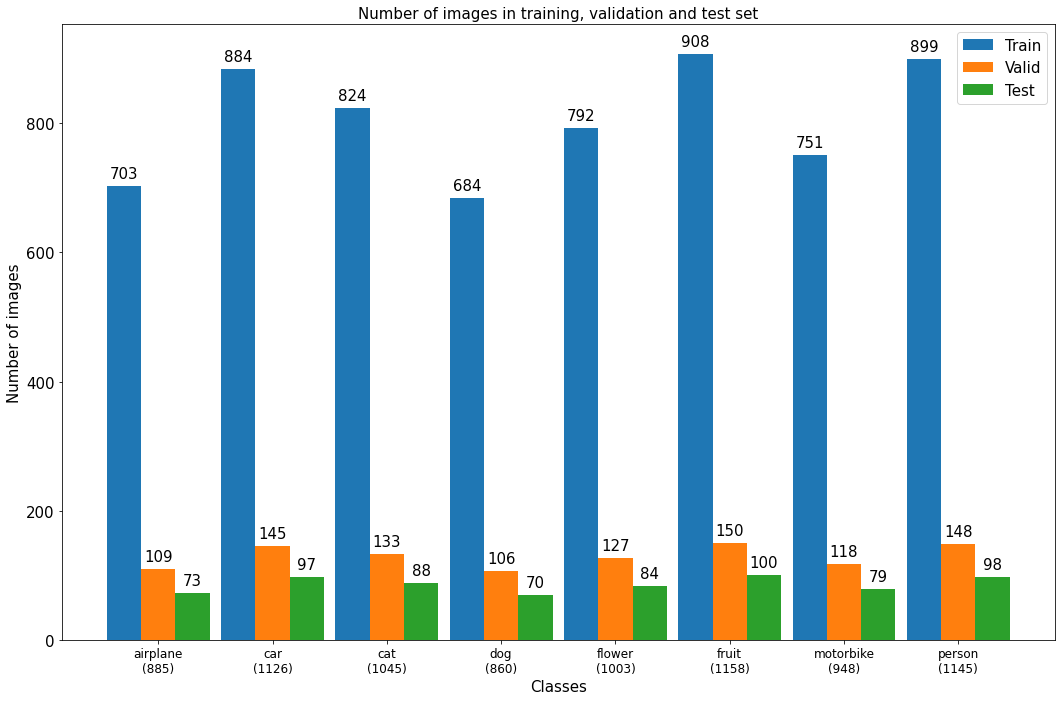

In [59]:
plt.rcParams["figure.figsize"] = [15,10]
bar1 = np.arange(len(classes_natural_images)) # the label locations
width = 0.3  # the width of the bars
bar2 = [i+width for i in bar1]
bar3 = [i+width for i in bar2]
fig, ax = plt.subplots()
rects1 = ax.bar(bar1,train_qty,width,label="Train")
rects2 = ax.bar(bar2,valid_qty,width,label="Valid")
rects3 = ax.bar(bar3,test_qty,width,label="Test")
xlabels = [f"{x1}\n({x2})" for x1, x2, in zip(classes_natural_images,total_qty)]
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes',fontsize=15)
ax.set_ylabel('Number of images',fontsize=15)
ax.set_title('Number of images in training, validation and test set',fontsize=15)
ax.set_xticks(bar1+width)
ax.set_xticklabels(xlabels,fontsize=12)
ax.legend(fontsize=15)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

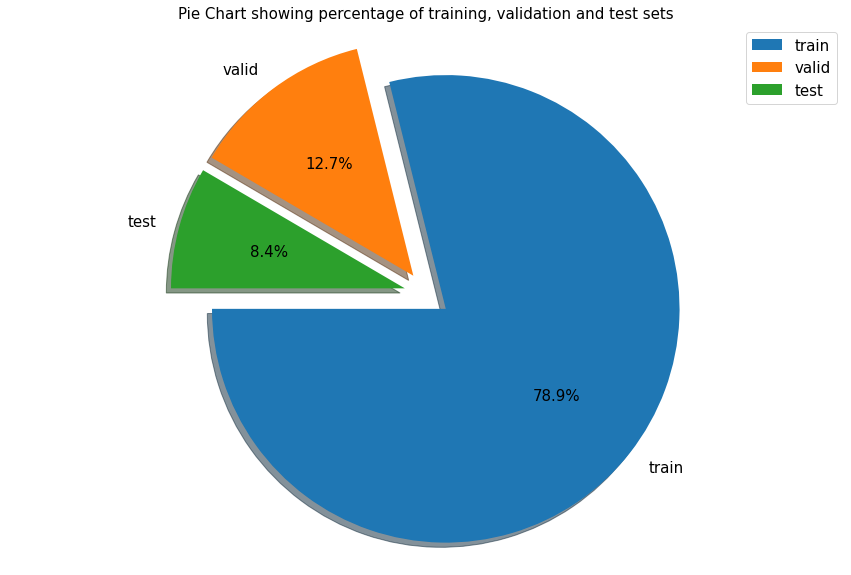

In [60]:
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams['font.size'] = 15.0
explode_0 = (0.1, 0.1, 0.1)
fig0, ax0, = plt.subplots()
ax0.pie(total_of_sets, explode=explode_0, labels=['train','valid','test'], autopct='%1.1f%%',
      shadow=True, startangle=180, counterclock=True)
ax0.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax0.legend(fontsize=15)
ax0.set_title('Pie Chart showing percentage of training, validation and test sets',fontsize=15)

plt.show()

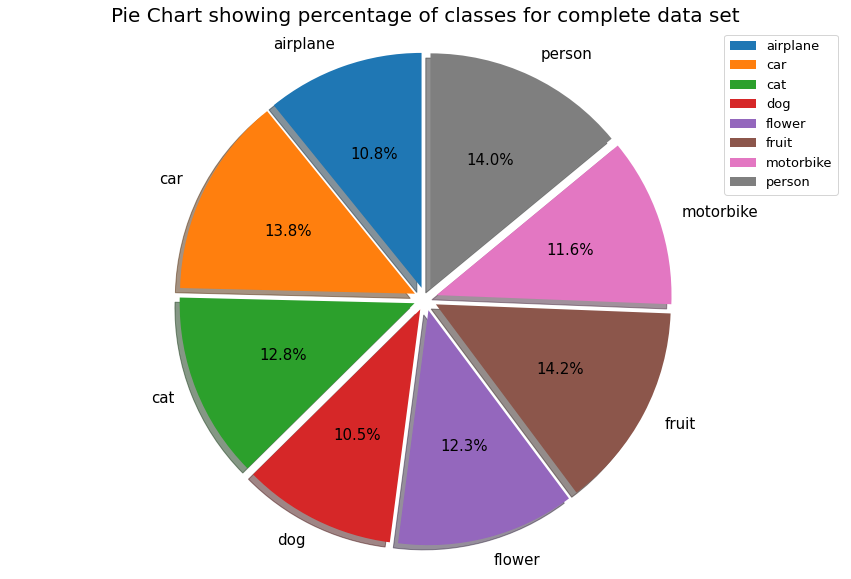

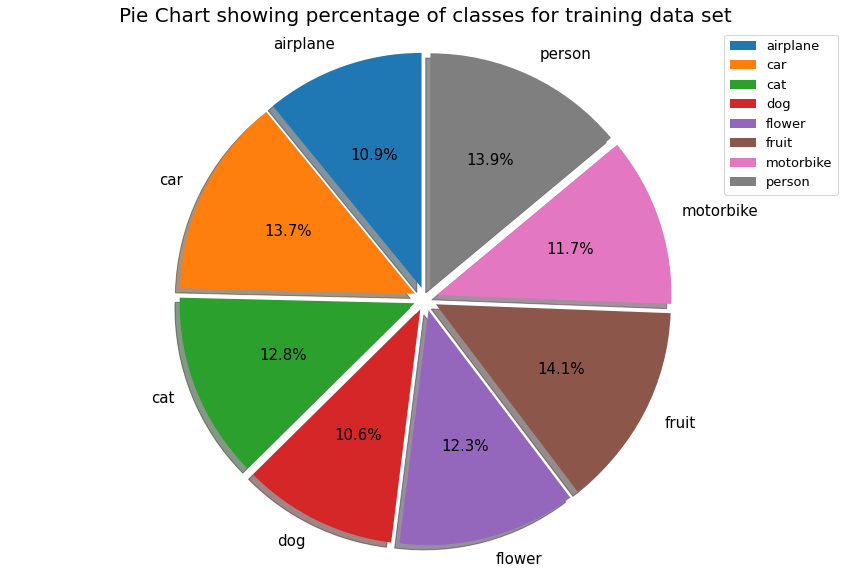

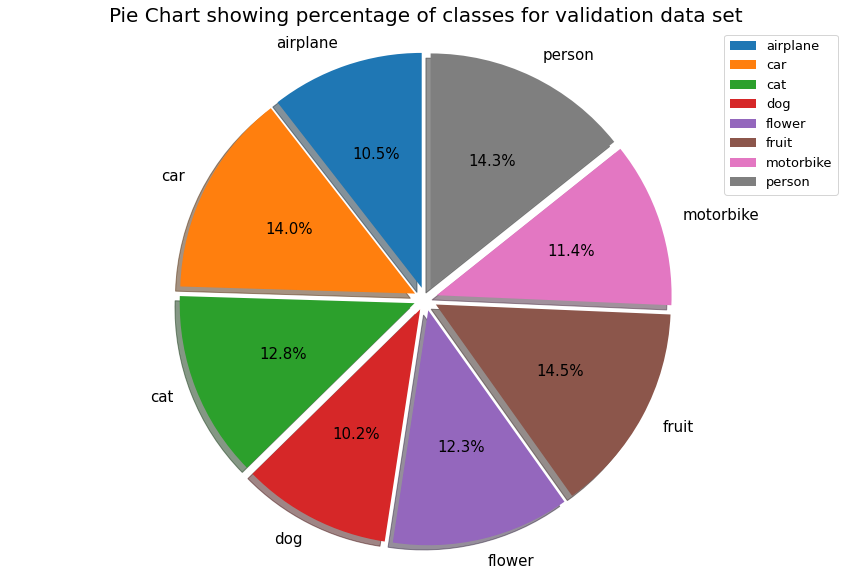

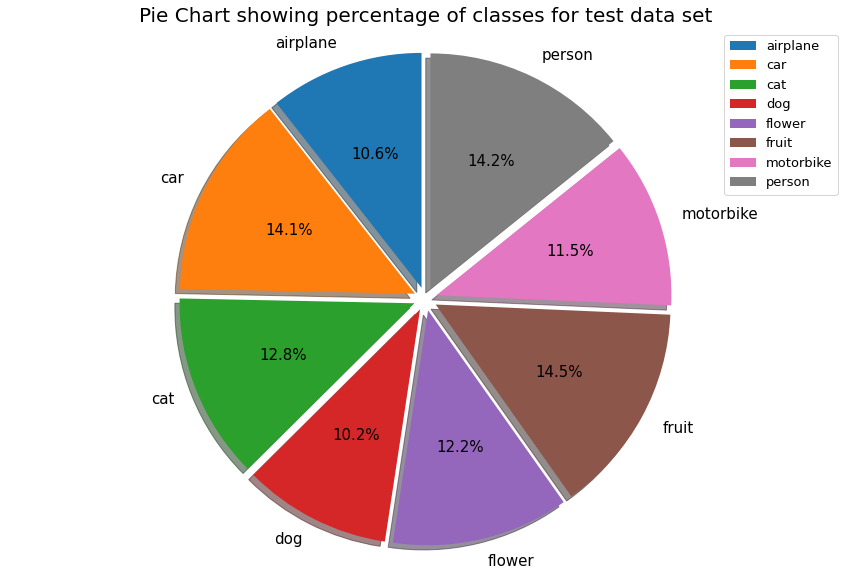

In [61]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)  


fig1, ax1, = plt.subplots()
fig2, ax2, = plt.subplots()
fig3, ax3, = plt.subplots()
fig4, ax4, = plt.subplots()
plt.rcParams['font.size'] = 15.0
plt.rcParams["figure.figsize"] = [15,10]
ax1.pie(total_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(fontsize=13)
ax1.set_title('Pie Chart showing percentage of classes for complete data set',fontsize=20)

ax2.pie(train_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.legend(fontsize=13)
ax2.set_title('Pie Chart showing percentage of classes for training data set',fontsize=20)

ax3.pie(valid_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.legend(fontsize=13)
ax3.set_title('Pie Chart showing percentage of classes for validation data set',fontsize=20)

ax4.pie(test_qty, explode=explode, labels=classes_natural_images, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.legend(fontsize=13)
ax4.set_title('Pie Chart showing percentage of classes for test data set',fontsize=20)

plt.show()

In [62]:
class_labels = os.listdir('data/natural_images/train')
print(class_labels)

['cat', 'car', 'fruit', 'dog', 'person', 'flower', 'motorbike', 'airplane']


#### Making the training, validation and test directories and preprocessing using ImageGenerator.flor_from_directory()

In [63]:

train_path = 'data/natural_images/train'
valid_path = 'data/natural_images/valid'
test_path = 'data/natural_images/test'

In [64]:
# Preprocessing the images and preparing the image batches 

train_set_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5)
valid_set_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5)
test_set_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(300,300), \
                         classes=['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'], batch_size=5, shuffle=False)

Found 6445 images belonging to 8 classes.
Found 1036 images belonging to 8 classes.
Found 689 images belonging to 8 classes.


In [65]:
# next(train_batches) to generate a batch of images and labels from the training set. 


imgs_set_aug, labels_set_aug = next(train_set_aug)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


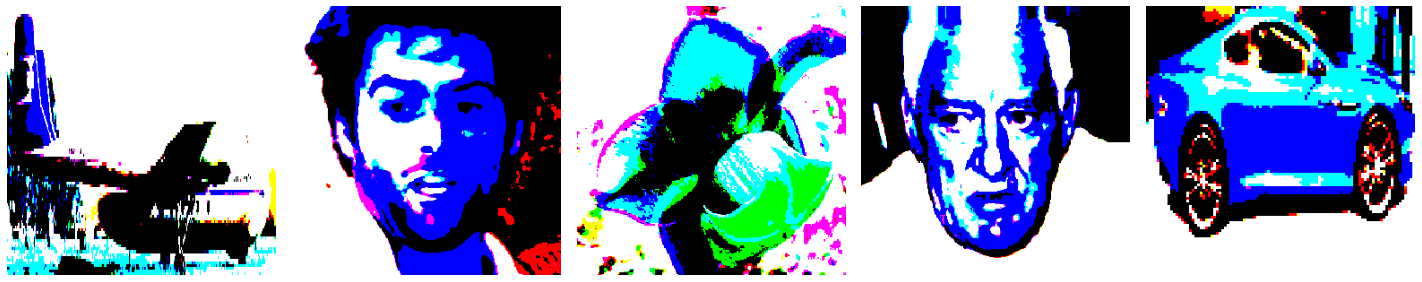

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


In [67]:
plotImages(imgs_set_aug)
print(labels_set_aug)

### Building the model

In [72]:
# Same simple 2 layer VGG16 architecture as we did earlier. That had the best performance, least overfitting and best generalization.

model_aug = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(300,300,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=8, activation='softmax')
])

In [73]:
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 360000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2880008   
Total params: 2,899,400
Trainable params: 2,899,400
Non-trainable params: 0
____________________________________________

In [74]:
# Compiling the model

model_aug.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [76]:
# Now it’s time to train the model.

augmented_model = model_aug.fit(x=train_set_aug,
                                steps_per_epoch=len(train_set_aug),
                                validation_data=valid_set_aug,
                                validation_steps=len(valid_set_aug),
                                epochs=10,
                                verbose=2
                               )

Epoch 1/10
1289/1289 - 262s - loss: 4.7097 - accuracy: 0.8073 - val_loss: 0.3930 - val_accuracy: 0.8726
Epoch 2/10
1289/1289 - 262s - loss: 0.0656 - accuracy: 0.9803 - val_loss: 0.5023 - val_accuracy: 0.8803
Epoch 3/10
1289/1289 - 263s - loss: 0.1070 - accuracy: 0.9812 - val_loss: 0.6641 - val_accuracy: 0.8571
Epoch 4/10
1289/1289 - 261s - loss: 0.0714 - accuracy: 0.9820 - val_loss: 0.5860 - val_accuracy: 0.8764
Epoch 5/10
1289/1289 - 262s - loss: 0.0197 - accuracy: 0.9947 - val_loss: 0.7388 - val_accuracy: 0.8764
Epoch 6/10
1289/1289 - 269s - loss: 0.0843 - accuracy: 0.9809 - val_loss: 1.0917 - val_accuracy: 0.8716
Epoch 7/10
1289/1289 - 252s - loss: 0.0364 - accuracy: 0.9901 - val_loss: 1.1426 - val_accuracy: 0.8571
Epoch 8/10
1289/1289 - 258s - loss: 0.0215 - accuracy: 0.9949 - val_loss: 1.0662 - val_accuracy: 0.8639
Epoch 9/10
1289/1289 - 246s - loss: 0.1565 - accuracy: 0.9822 - val_loss: 1.0669 - val_accuracy: 0.8726
Epoch 10/10
1289/1289 - 245s - loss: 0.0216 - accuracy: 0.9955 -

In [77]:
# Augmentation did not really reduce overfitting by much. But let's see how it does on the test set

In [78]:
augmented_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

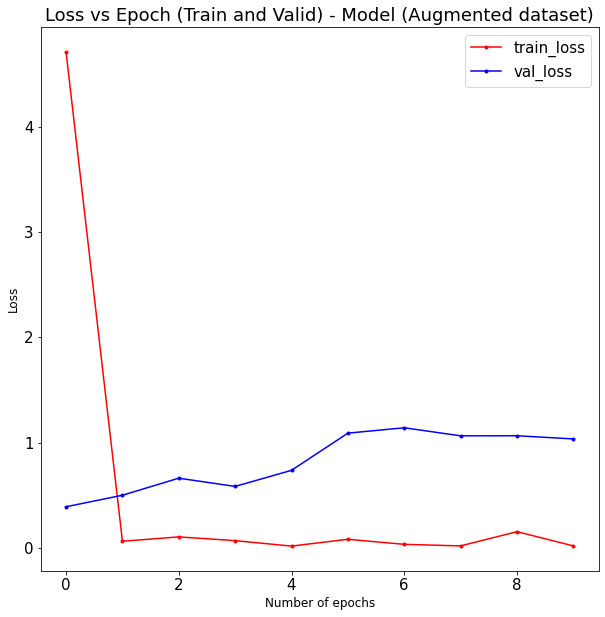

In [79]:
# plotting the epochs on the x axis and loss on y axis. Red is for training accuracy and blue for validation set
fig_aug, ax_aug = plt.subplots(figsize=(10,10))
ax_aug.set_title('Loss vs Epoch (Train and Valid) - Model (Augmented dataset)')
ax_aug.plot(augmented_model.history["loss"],'r', marker='.', label="train_loss")
ax_aug.plot(augmented_model.history["val_loss"],'b', marker='.', label="val_loss")
ax_aug.set_xlabel('Number of epochs',fontsize=12)
ax_aug.set_ylabel('Loss',fontsize=12)
ax_aug.legend()

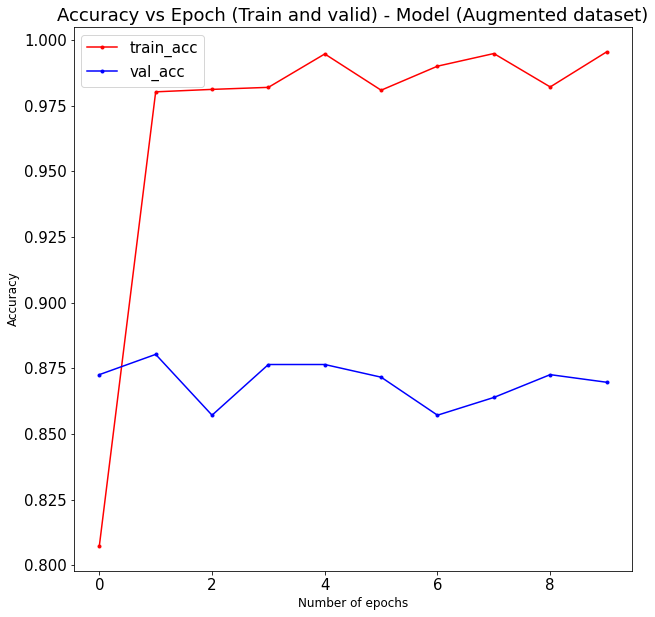

In [80]:
# plotting the epochs on the x axis and accuracy on y axis. Red is for training accuracy and blue for validation set
fig_aug_2, ax_aug_2 = plt.subplots(figsize=(10,10))
ax_aug_2.set_title('Accuracy vs Epoch (Train and valid) - Model (Augmented dataset)')
ax_aug_2.plot(augmented_model.history["accuracy"],'r', marker='.', label="train_acc")
ax_aug_2.plot(augmented_model.history["val_accuracy"],'b', marker='.', label="val_acc")
ax_aug_2.set_xlabel('Number of epochs',fontsize=12)
ax_aug_2.set_ylabel('Accuracy',fontsize=12)
ax_aug_2.legend()

### Testing the model on Test data

In [81]:
# Preparing The Test Data

# next(test_batches) to extract a batch of images and their corresponding labels from the test set.

test_imgs_set_aug, test_labels_set_aug = next(test_set_aug)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


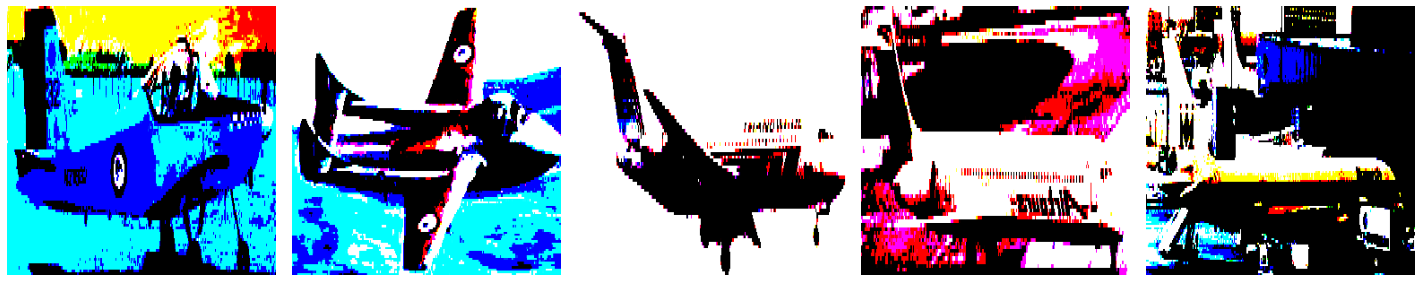

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [82]:
plotImages(test_imgs_set_aug)
print(test_labels_set_aug)

In [83]:
# Just as we saw before, the test set is labeled with a one-hot encoding 
# [1. 0. 0. 0. 0. 0. 0. 0.] is for airplane
# [0. 1. 0. 0. 0. 0. 0. 0.] is for car
# [0. 0. 1. 0. 0. 0. 0. 0.] is for cat
# and so on

In [84]:
# Predicting On The Test Data

predictions_aug = model_aug.predict(x=test_set_aug, steps=len(test_set_aug), verbose=0)

In [85]:
np.round(predictions_aug)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [86]:
# These are the labels that the model is predicting for our images.

In [87]:
# Plotting Predictions With A Confusion Matrix

cm_aug = confusion_matrix(y_true=test_set_aug.classes, y_pred=np.argmax(predictions_aug, axis=-1))

In [88]:
# Unshuffled test set labels

test_set_aug.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [89]:
model_aug.predict_classes(test_set_aug)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 2, 7, 2,
       2, 3, 2, 2, 2, 2, 2, 3, 2, 7, 4, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2,
       3, 4, 2, 2, 3, 4, 2, 2, 3, 2, 2, 2, 4, 7, 4, 2, 2, 7, 0, 4, 2, 3,
       2, 2, 7, 3, 2, 6, 2, 2, 3, 3, 3, 3, 7, 4, 2, 2, 2, 4, 6, 3, 4, 3,
       3, 3, 7, 2, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 2, 6,
       3, 4, 3, 3, 0, 0, 4, 7, 2, 3, 3, 1, 3, 7, 3,

In [90]:
# We can notice some incorrect predictions at a quick glance. Let's plot the confusion matrix

In [91]:
test_set_aug.class_indices

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [92]:
# Finally, we plot the confusion matrix.

Confusion matrix, without normalization
[[ 68   0   3   2   0   0   0   0]
 [  0  94   0   0   2   1   0   0]
 [  1   1  51  18  10   0   1   6]
 [  4   2   7  44   7   0   3   3]
 [  1   0   5   2  73   0   3   0]
 [  0   0   0   0   0 100   0   0]
 [  1   0   0   0   1   0  77   0]
 [  0   0   0   0   0   0   0  98]]


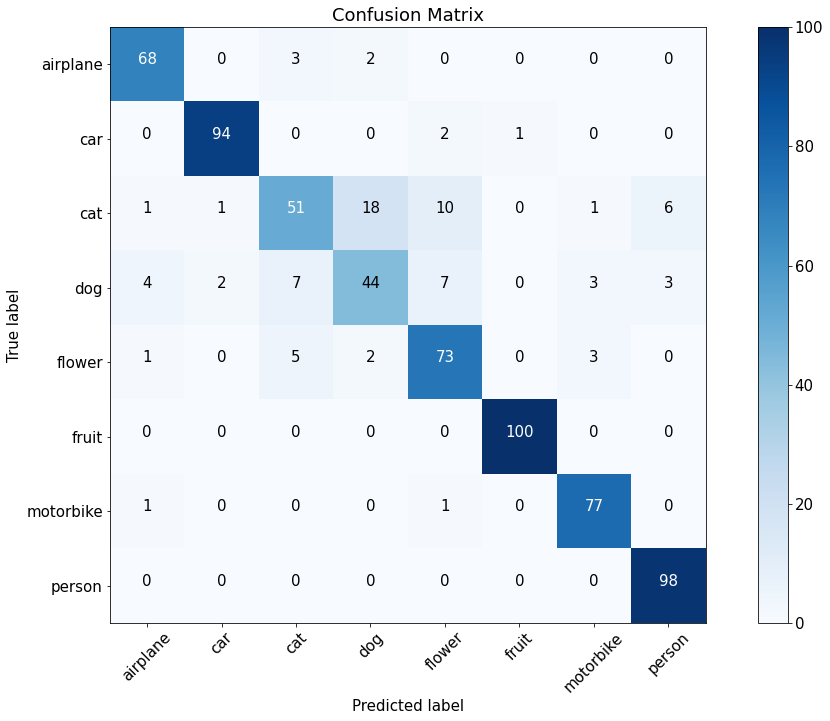

In [93]:
cm_plot_labels = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
plot_confusion_matrix(cm=cm_aug, classes=cm_plot_labels, title='Confusion Matrix')

In [94]:
# Evaluate the model
scores_cnn_aug = model_aug.evaluate(test_set_aug)
print ("Accuracy: %.2f%%" %(scores_cnn_aug[1]*100))

138/138 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.80 - ETA: 3s - loss: 0.9434 - accuracy: 0.86 - ETA: 4s - loss: 1.2629 - accuracy: 0.88 - ETA: 4s - loss: 0.9186 - accuracy: 0.91 - ETA: 4s - loss: 0.7211 - accuracy: 0.93 - ETA: 4s - loss: 0.6478 - accuracy: 0.92 - ETA: 4s - loss: 0.5481 - accuracy: 0.93 - ETA: 4s - loss: 0.5334 - accuracy: 0.93 - ETA: 4s - loss: 0.4706 - accuracy: 0.94 - ETA: 4s - loss: 0.4211 - accuracy: 0.94 - ETA: 4s - loss: 0.3810 - accuracy: 0.95 - ETA: 4s - loss: 0.3479 - accuracy: 0.95 - ETA: 3s - loss: 0.3201 - accuracy: 0.96 - ETA: 3s - loss: 0.3504 - accuracy: 0.95 - ETA: 3s - loss: 0.3358 - accuracy: 0.95 - ETA: 3s - loss: 0.3619 - accuracy: 0.94 - ETA: 3s - loss: 0.3400 - accuracy: 0.95 - ETA: 3s - loss: 0.3630 - accuracy: 0.93 - ETA: 3s - loss: 0.4401 - accuracy: 0.92 - ETA: 3s - loss: 0.6073 - accuracy: 0.90 - ETA: 3s - loss: 0.6326 - accuracy: 0.90 - ETA: 3s - loss: 0.7014 - accuracy: 0.89 - ETA: 3s - loss: 0.8182 - accuracy

#### Finally, comparing the ROC AUC scores between the original dataset model and the augmented dataset model

In [99]:
# Let's first get the original predictions and assign to variable y_pred

y_pred = my_model.predict(test_set)

In [100]:
# similarly, for the augmented dataset, assigning the predictions to a variable

y_pred_aug = model_aug.predict_proba(test_set_aug)

Instructions for updating:
Please use `model.predict()` instead.


In [102]:
# The following code for ROC AUC scores is taken directly from scikitlearn's documentation for multi-class problems
# Here, the augmented dataset model's ROC AUC scores are printed
# One-vs-One score is the score between each and every class. It is converted to a binary classifier
# For example, airplane vs car is one binary classifier. car vs cat is another binary classifier
# One-vs-Rest score is the score of one class vs all the other classes. It is also converted to a binary classifier
# For example, airplane vs all other classes is one binary classifier. car vs all other classes is another binary classifier, and so on.
# The macro score is just the average of all the binary classifiers
# weighted by prevalence is the score calculated with the weight from each binary classifier

aug_macro_roc_auc_ovo = roc_auc_score(test_set_aug.classes, y_pred_aug, multi_class="ovo",
                                  average="macro")
aug_weighted_roc_auc_ovo = roc_auc_score(test_set_aug.classes, y_pred_aug, multi_class="ovo",
                                     average="weighted")
aug_macro_roc_auc_ovr = roc_auc_score(test_set_aug.classes, y_pred_aug, multi_class="ovr",
                                  average="macro")
aug_weighted_roc_auc_ovr = roc_auc_score(test_set_aug.classes, y_pred_aug, multi_class="ovr",
                                     average="weighted")
print("For Augmented Set")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(aug_macro_roc_auc_ovo, aug_weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(aug_macro_roc_auc_ovr, aug_weighted_roc_auc_ovr))

For Augmented Set
One-vs-One ROC AUC scores:
0.983548 (macro),
0.984706 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.984659 (macro),
0.986037 (weighted by prevalence)


In [104]:
# The above was for the augmented dataset

# Now, for the original dataset
my_macro_roc_auc_ovo = roc_auc_score(test_set.classes, y_pred, multi_class="ovo",
                                  average="macro")
my_weighted_roc_auc_ovo = roc_auc_score(test_set.classes, y_pred, multi_class="ovo",
                                     average="weighted")
my_macro_roc_auc_ovr = roc_auc_score(test_set.classes, y_pred, multi_class="ovr",
                                  average="macro")
my_weighted_roc_auc_ovr = roc_auc_score(test_set.classes, y_pred, multi_class="ovr",
                                     average="weighted")
print("For Original Set")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(my_macro_roc_auc_ovo, my_weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(my_macro_roc_auc_ovr, my_weighted_roc_auc_ovr))

For Original Set
One-vs-One ROC AUC scores:
0.983770 (macro),
0.985058 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.984913 (macro),
0.986553 (weighted by prevalence)


We can see that both datasets perform really well, but the original dataset model is slightly better, <br>
which we can verify with the test accuracy score differences between the two models as well<br>
<br>
For the original dataset, test accuracy was: 89.40%<br>
For the augmented dataset, test accuracy was: 87.81%<br>
<br>
The accuracies vary by +/- 2% after running the model each time. During the last model building, the original dataset performed slightly better than the augmented one<br>


# Summary

*Note: The following summary cells are left in edit mode due to the tables getting distorted after running the cell*

### First CNN Model

Number of images used for training: 5174<br>
    <br>
    
Model: "sequential"<br>
_________________________________________________________________<br>
Layer (type)                 Output Shape              Param #   <br>
=================================================================<br>
conv2d (Conv2D)              (None, 300, 300, 32)      896       <br>
_________________________________________________________________<br>
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         <br>
_________________________________________________________________<br>
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     <br>
_________________________________________________________________<br>
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         <br>
_________________________________________________________________<br>
flatten (Flatten)            (None, 360000)            0         <br>
_________________________________________________________________<br>
dense (Dense)                (None, 8)                 2880008   <br>
=================================================================<br>
Total params: 2,899,400<br>
Trainable params: 2,899,400<br>
Non-trainable params: 0<br>
_________________________________________________________________<br>

Training acccuracies:<br>
<br>
Epoch 1/10<br>
1035/1035 - 216s - loss: 8.5000 - accuracy: 0.8025 - val_loss: 0.5966 - val_accuracy: 0.8697<br>
Epoch 2/10<br>
1035/1035 - 211s - loss: 0.0990 - accuracy: 0.9720 - val_loss: 0.6864 - val_accuracy: 0.8832<br>
Epoch 3/10<br>
1035/1035 - 210s - loss: 0.0291 - accuracy: 0.9917 - val_loss: 0.8857 - val_accuracy: 0.8417<br>
Epoch 4/10<br>
1035/1035 - 210s - loss: 0.0761 - accuracy: 0.9861 - val_loss: 0.9148 - val_accuracy: 0.8707<br>
Epoch 5/10<br>
1035/1035 - 209s - loss: 0.0700 - accuracy: 0.9838 - val_loss: 1.3729 - val_accuracy: 0.8398<br>
Epoch 6/10<br>
1035/1035 - 209s - loss: 0.1021 - accuracy: 0.9768 - val_loss: 0.7074 - val_accuracy: 0.8678<br>
Epoch 7/10<br>
1035/1035 - 210s - loss: 0.0295 - accuracy: 0.9938 - val_loss: 0.7500 - val_accuracy: 0.8774<br>
Epoch 8/10<br>
1035/1035 - 209s - loss: 0.0329 - accuracy: 0.9934 - val_loss: 0.9509 - val_accuracy: 0.8745<br>
Epoch 9/10<br>
1035/1035 - 208s - loss: 0.0107 - accuracy: 0.9977 - val_loss: 1.2695 - val_accuracy: 0.8629<br>
Epoch 10/10<br>
1035/1035 - 209s - loss: 0.0402 - accuracy: 0.9936 - val_loss: 1.0410 - val_accuracy: 0.8745<br>
                <br>
                
Confusion Matrix:<br>
[ 66   0   7   0   0   0   0   0]<br>
[  0  96   0   0   1   0   0   0]<br>
[  1   1  69  10   4   1   0   2]<br>
[  1   0  26  31  10   0   0   2]<br>
[  0   1   2   0  80   0   0   1]<br>
[  0   0   0   0   0 100   0   0]<br>
[  1   0   1   0   1   0  76   0]<br>
[  0   0   0   0   0   0   0  98]<br>
<br>

Test set accuracy:<br>
89.40%<br>
<br>

One-vs-One ROC AUC scores:<br>
0.983770 (macro),<br>
0.985058 (weighted by prevalence)<br>
One-vs-Rest ROC AUC scores:<br>
0.984913 (macro),<br>
0.986553 (weighted by prevalence)<br>

### Hyperparameter tuned model

Number of images used for training: 1380<br>
<br>

Model: "sequential_2"<br>
_________________________________________________________________<br>
Layer (type)                 Output Shape              Param #   <br>
=================================================================<br>
conv2d_2 (Conv2D)            (None, 300, 300, 32)      896       <br>
_________________________________________________________________<br>
max_pooling2d_2 (MaxPooling2 (None, 150, 150, 32)      0         <br>
_________________________________________________________________<br>
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     <br>
_________________________________________________________________<br>
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 64)        0         <br>
_________________________________________________________________<br>
flatten_1 (Flatten)          (None, 360000)            0         <br>
_________________________________________________________________<br>
dense_1 (Dense)              (None, 8)                 2880008   <br>
=================================================================<br>
Total params: 2,899,400<br>
Trainable params: 2,899,400<br>
Non-trainable params: 0<br>
_________________________________________________________________<br>
<br>

Before tuning:<br>
Epoch 1/10<br>
276/276 - 61s - loss: 23.4691 - accuracy: 0.6913 - val_loss: 1.6428 - val_accuracy: 0.8333<br>
Epoch 2/10<br>
276/276 - 59s - loss: 0.3758 - accuracy: 0.9457 - val_loss: 1.7721 - val_accuracy: 0.8514<br>
Epoch 3/10<br>
276/276 - 59s - loss: 0.0888 - accuracy: 0.9804 - val_loss: 1.4862 - val_accuracy: 0.8587<br>
Epoch 4/10<br>
276/276 - 59s - loss: 0.1016 - accuracy: 0.9870 - val_loss: 2.4891 - val_accuracy: 0.8406<br>
Epoch 5/10<br>
276/276 - 61s - loss: 0.1511 - accuracy: 0.9855 - val_loss: 1.6609 - val_accuracy: 0.8587<br>
Epoch 6/10<br>
276/276 - 55s - loss: 0.0232 - accuracy: 0.9971 - val_loss: 3.5536 - val_accuracy: 0.7717<br>
Epoch 7/10<br>
276/276 - 55s - loss: 0.1364 - accuracy: 0.9790 - val_loss: 2.0322 - val_accuracy: 0.8551<br>
Epoch 8/10<br>
276/276 - 55s - loss: 0.1985 - accuracy: 0.9833 - val_loss: 1.8885 - val_accuracy: 0.8514<br>
Epoch 9/10<br>
276/276 - 55s - loss: 0.1060 - accuracy: 0.9833 - val_loss: 3.1521 - val_accuracy: 0.7862<br>
Epoch 10/10<br>
276/276 - 55s - loss: 0.1709 - accuracy: 0.9812 - val_loss: 1.4633 - val_accuracy: 0.8804<br>
<br>

Confusion matrix:<br>
 [ 9  0  1  1  0  0  0  0]<br>
 [ 0 15  0  0  0  0  0  0]<br>
 [ 1  1  5  4  0  0  0  2]<br>
 [ 0  0  2  6  0  0  1  2]<br>
 [ 0  0  0  4  9  0  0  0]<br>
 [ 0  0  0  0  0 15  0  0]<br>
 [ 0  1  0  0  0  0 11  0]<br>
 [ 0  0  0  0  0  0  0 15]<br>
 <br>
 
 Test set accuracy:<br>
 80.95%<br>
 <br>
 
 
 After tuning:<br>
 <br>
Model: "sequential"<br>
_________________________________________________________________<br>
Layer (type)                 Output Shape              Param #   <br>
=================================================================<br>
conv2d (Conv2D)              (None, 300, 300, 16)      448       <br>
_________________________________________________________________<br>
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         <br>
_________________________________________________________________<br>
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      <br>
_________________________________________________________________<br>
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         <br>
_________________________________________________________________<br>
conv2d_2 (Conv2D)            (None, 75, 75, 128)       36992     <br>
_________________________________________________________________<br>
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 128)       0         <br>
_________________________________________________________________<br>
flatten (Flatten)            (None, 175232)            0         <br>
_________________________________________________________________<br>
dense (Dense)                (None, 8)                 1401864   <br>
_________________________________________________________________<br>
activation (Activation)      (None, 8)                 0         <br>
=================================================================<br>
Total params: 1,443,944<br>
Trainable params: 1,443,944<br>
Non-trainable params: 0<br>
_________________________________________________________________<br>

Epoch 1/5<br>
276/276 - loss: 0.2611 - accuracy: 0.9283 - val_loss: 0.9035 - val_accuracy: 0.7355<br>
Epoch 2/5<br>
276/276 - loss: 0.2381 - accuracy: 0.9507 - val_loss: 1.0405 - val_accuracy: 0.7754<br>
Epoch 3/5<br>
276/276 - loss: 0.1410 - accuracy: 0.9601 - val_loss: 1.8351 - val_accuracy: 0.6920<br>
Epoch 4/5<br>
276/276 - loss: 0.3197 - accuracy: 0.9391 - val_loss: 2.9748 - val_accuracy: 0.6703<br>
Epoch 5/5<br>
276/276 - loss: 0.7930 - accuracy: 0.8877 - val_loss: 2.0812 - val_accuracy: 0.6667<br>
<br>
 
 Confusion matrix:<br>
 [ 6  1  1  1  1  0  1  0]<br>
 [ 2  9  0  1  2  1  0  0]<br>
 [ 0  2  2  2  6  0  0  1]<br>
 [ 1  1  3  1  4  1  0  0]<br>
 [ 0  0  0  1 11  0  0  1]<br>
 [ 0  2  0  0  0 12  1  0]<br>
 [ 0  2  1  0  0  0  9  0]<br>
 [ 1  0  0  0  1  0  0 13]<br>
 <br>
 
 Test set accuracy: 60.00%<br>

#### Ensembles

Number of images used for training: 1380<br>

CNN : 1<br>
CNN Model 1: Epochs=5, Training accuracy=0.94956, Validation accuracy=0.85328<br>
CNN : 2<br>
CNN Model 2: Epochs=5, Training accuracy=0.94356, Validation accuracy=0.84363<br>
CNN : 3<br>
CNN Model 3: Epochs=5, Training accuracy=0.92907, Validation accuracy=0.83108<br>
CNN : 4<br>
CNN Model 4: Epochs=5, Training accuracy=0.94240, Validation accuracy=0.84170<br>
<br>

Confusion Matrix:<br>
 [54 10  8  0  1  0  0  0]<br>
 [ 0 83 12  2  0  0  0  0]<br>
 [ 0  1 57 22  7  1  0  0]<br>
 [ 0  0 33 23 13  1  0  0]<br>
 [ 0  0  2 14 68  0  0  0]<br>
 [ 0  0  0  2  7 91  0  0]<br>
 [ 0  0  1  0  3  3 72  0]<br>
 [ 0  0  0  1  0  1  3 93]<br>
 <br>
 
 Test set accurcay: 78.52%<br> 

### Agmented dataset model

Number of images used for training: 6445<br>
    <br>
    

Model: "sequential_1"<br>
_________________________________________________________________<br>
Layer (type)                 Output Shape              Param #   <br>
=================================================================<br>
conv2d_2 (Conv2D)            (None, 300, 300, 32)      896       <br>
_________________________________________________________________<br>
max_pooling2d_2 (MaxPooling2 (None, 150, 150, 32)      0         <br>
_________________________________________________________________<br>
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     <br>
_________________________________________________________________<br>
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 64)        0         <br>
_________________________________________________________________<br>
flatten_1 (Flatten)          (None, 360000)            0         <br>
_________________________________________________________________<br>
dense_1 (Dense)              (None, 8)                 2880008   <br>
=================================================================<br>
Total params: 2,899,400<br>
Trainable params: 2,899,400<br>
Non-trainable params: 0<br>
_________________________________________________________________<br>
<br>



Confusion matrix:<br>
 [ 68   0   3   2   0   0   0   0]<br>
 [  0  94   0   0   2   1   0   0]<br>
 [  1   1  51  18  10   0   1   6]<br>
 [  4   2   7  44   7   0   3   3]<br>
 [  1   0   5   2  73   0   3   0]<br>
 [  0   0   0   0   0 100   0   0]<br>
 [  1   0   0   0   1   0  77   0]<br>
 [  0   0   0   0   0   0   0  98]<br>
 <br>
 
Test set accuracy: 87.81%<br>
<br>

ROC AUC Scores:<br>
One-vs-One ROC AUC scores:<br>
0.983548 (macro),<br>
0.984706 (weighted by prevalence)<br>
One-vs-Rest ROC AUC scores:<br>
0.984659 (macro),<br>
0.986037 (weighted by prevalence)<br>